Parte 1
===

In [1]:
# !pip install pandas-profiling --user
# !pip install imbalanced-learn==0.10.0 --user

In [2]:
# import math

import warnings as ws
ws.filterwarnings("ignore")

import pickle
import numpy as np
import pandas as pd
pd.set_option('float_format', '{:,.2f}'.format)

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
%matplotlib inline

from pandas_profiling import ProfileReport

from collections import Counter

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.combine import SMOTETomek

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split

## 1. Análisis exploratorio de los datos

In [3]:
df = pd.read_csv('data/Usuarios_Reparadora.csv', encoding='utf-8', index_col=0).reset_index(drop=True)

In [4]:
# Separamos el conjunto de datos

# Caraterísticas para modelado
features_df = df.drop(columns='Y')

# Variable objetivo
target = df.Y

features_df.shape, target.shape

((2896, 80), (2896,))

### Análisis de la variable objetivo

In [5]:
target.isna().sum()

0

Una consideración importante es que la variable objetivo no tenga datos perdidos o nulos, lo cual es el caso.

In [6]:
target_vc = target.value_counts()
pd.DataFrame(zip((target_vc.tolist()),(target_vc * 100 / target.shape[0]).tolist()),
             columns=['count', '%'], index=target_vc.index)

,count,%
0,2811,97.06
1,85,2.94


<AxesSubplot:xlabel='Y', ylabel='count'>

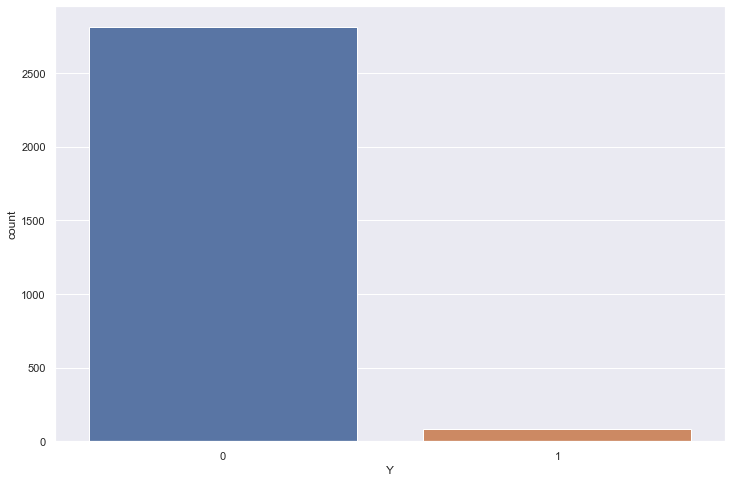

In [7]:
f, ax = plt.subplots(figsize=(12, 8))
sns.countplot(x=target, ax=ax)

La variable objetivo representa los usuarios seleccionados para reparación de deuda. El valor 0 indica que han sido **Rechazados** y el valor 1 que han sido **Aceptados**. Puede notarse que la proporción de personas aceptadas es muy baja, apenas del **3%** de toda la muestra de datos, lo que solo nos deja 85 de 2896 usuarios aceptados.

### Análisis de características con valores perdidos

In [8]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 80 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Pais                           2896 non-null   object 
 1   edad                           2718 non-null   float64
 2   genero                         2896 non-null   object 
 3   Antiguedad                     2896 non-null   object 
 4   nombre_estado                  122 non-null    object 
 5   Tiene_creditos                 2896 non-null   int64  
 6   Creditos                       2896 non-null   int64  
 7   saldo_actual                   2893 non-null   float64
 8   saldo_vencido                  2893 non-null   float64
 9   mop_historico                  2721 non-null   object 
 10  numero_pagos_vencidos          1137 non-null   float64
 11  Promedio de limite_credito     1820 non-null   float64
 12  Promedio de credito_maximo     2888 non-null   f

El reporte anterior permite identificar campos con **alto porcentaje de valores perdidos o nulos**. La idea es eliminados del conjunto de datos, ya que por insuficiencia de información, no aportan mucho valor en el modelado.

In [9]:
missing_data = features_df.isna().sum() / features_df.shape[0]
missing_data.describe()

count   80.00
mean     0.57
std      0.43
min      0.00
25%      0.05
50%      0.83
75%      0.98
max      1.00
dtype: float64

La primera regla de limpieza será eliminar las características que tengan un porcentaje de valores perdidos **superior a 83%**, correspondiente al valor de la mediana y donde considero son variables que no aportarán valor, ya que labores de imputación podrían resultar en sesgos o sobreajustes del modelo.

#### Eliminación de características con valores perdidos

In [10]:
# Variables que se van a eliminar

missing = missing_data > missing_data.describe()['50%']
print(f"Cantidad de columnas missing: {missing[missing].shape[0]}")
print(f"Nombres de columnas missing:\n{', '.join(missing[missing].index.tolist())}")

Cantidad de columnas missing: 39
Nombres de columnas missing:
nombre_estado, Activo_saldo_actual, Activo_saldo_vencido, %_Activo, Activos_pagos_vencidos, Activos_garantia, Autos_saldo_actual, Autos_saldo_vencido, %_Autos, Autos_pagos_vencidos, Autos_garantia, Educacion_saldo_actual, Educacion_saldo_vencido, %_educuacion, Educacion_pagos_vencidos, Educacion_garantia, Libranza_saldo_actual, Libranza_saldo_vencido, %_libranza, Libranza_pagos_vencidos, Libranza_garantia, Microcredito_saldo_actual, Microcredito_saldo_vencido, %_microcredito, microcredito_pagos_vencidos, microcredito_garantia, Otros_saldo_actual, Otros_saldo_vencido, %_otro, Otros_pagos_vencidos, Otros_garantia, %_tarjeta, Tarjeta_pagos_vencidos, Tarjeta_garantia, Vivienda_saldo_actual, Vivienda_saldo_vencido, %_vivienda, Vivienda_pagos_vencidos, Vivienda_garantia


El reporte anterior muestra que se eliminarán **39 características** de la muestra. La primera de ellas llamada **nombre_estado**, indica el nombre del departamento donde se localiza el usuario, al tener tantos valores nulos no tienen nungún valor. 

Por otro lado, tenemos un grupo de variables que representan los **productos financieros** que tienen los usuarios. Por ejemplo, las variables *Libranza_saldo_actual, Libranza_saldo_vencido, %_libranza, Libranza_pagos_vencidos, Libranza_garantia*, representan el producto **Crédito de Libranza**. Vemos que tiene un saldo actual o el valor presente de la deuda, un valor de saldo vencido (pendiente por pagar), el porcentaje que representa el saldo actual de libranza sobre el saldo total del usuario **(variable saldo_total)**, cantidad de pagos vencidos y un valor binario que indica si la deuda tiene o no garantía.

Existen varios grupos de estas variables y por tanto, considerando su significado, tienen mucha incidencia en la decisión de ser o no aceptados por la reparadora. Sin embargo, considerando el alto porcentaje de valores perdidos, vamos a prescindir de estas variables. Tengamos en cuenta que los valores de saldo también se ven reflejados en las variables **saldo_actual** y **saldo_vencido**.

Notese algo particular en el listado de variables, al bloque **Tarjeta de Crédito** le faltan las variables de saldo actual y vencido, en este listado de variables a eliminar, significa que no cumplieron el criterio de eliminación seleccionado. Por tanto, las variables **Tarjeta_credito_saldo_actual y Tarjeta_credito_saldo_vencido** las vamos a eliminar del conjunto de datos.

In [11]:
missing_others = ['Tarjeta_credito_saldo_actual', 'Tarjeta_credito_saldo_vencido']

missing_columns = missing[missing].index.tolist()
for i, col in enumerate(missing_others):
    missing_columns.insert(missing_columns.index('%_tarjeta'), col)
    
print(f"Cantidad de columnas missing: {len(missing_columns)}")
print(f"Nombres de columnas missing:\n{', '.join(missing_columns)}")

Cantidad de columnas missing: 41
Nombres de columnas missing:
nombre_estado, Activo_saldo_actual, Activo_saldo_vencido, %_Activo, Activos_pagos_vencidos, Activos_garantia, Autos_saldo_actual, Autos_saldo_vencido, %_Autos, Autos_pagos_vencidos, Autos_garantia, Educacion_saldo_actual, Educacion_saldo_vencido, %_educuacion, Educacion_pagos_vencidos, Educacion_garantia, Libranza_saldo_actual, Libranza_saldo_vencido, %_libranza, Libranza_pagos_vencidos, Libranza_garantia, Microcredito_saldo_actual, Microcredito_saldo_vencido, %_microcredito, microcredito_pagos_vencidos, microcredito_garantia, Otros_saldo_actual, Otros_saldo_vencido, %_otro, Otros_pagos_vencidos, Otros_garantia, Tarjeta_credito_saldo_actual, Tarjeta_credito_saldo_vencido, %_tarjeta, Tarjeta_pagos_vencidos, Tarjeta_garantia, Vivienda_saldo_actual, Vivienda_saldo_vencido, %_vivienda, Vivienda_pagos_vencidos, Vivienda_garantia


In [12]:
# Variables que se van a conservar

no_missing = missing_data <= missing_data.describe()['50%']
no_missing_columns = no_missing[no_missing].index.tolist()
no_missing_columns = [i for i in no_missing_columns if i not in missing_others]

print(f"Cantidad de columnas seleccionadas no missing: {len(no_missing_columns)}")
print(f"Nombres de columnas seleccionadas no missing: {', '.join(no_missing_columns)}")

Cantidad de columnas seleccionadas no missing: 39
Nombres de columnas seleccionadas no missing: Pais, edad, genero, Antiguedad, Tiene_creditos, Creditos, saldo_actual, saldo_vencido, mop_historico, numero_pagos_vencidos, Promedio de limite_credito, Promedio de credito_maximo, Promedio de cantidad_cuotas, Promedio de valor_cuota, ahorro_impacto, bienestar_financiero_impacto, coaching_impacto, gestion_de_gastos_impacto, score, perfil_usuario, sistema_operativo, Desinstalaciones, Tiene_ahorro, monto_ahorro, monto_bloqueado, monto_total, Tiene_seguros, Seguros, Comunicaciones_saldo_actual, Comunicaciones_saldo_vencido, %_comunicaciones, Comunicaciones_pagos_vencidos, Comunicaciones_garantia, Consumo_saldo_actual, Consumo_saldo_vencido, %_consumo, consumo_pagos_vencidos, consumo_garantia, Garantia


Quedaron **39 características** que cumplen con el criterio de valores perdidos. Vamos a aplicar este cambio en el conjunto de datos original.

In [13]:
df = df[no_missing_columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Pais                           2896 non-null   object 
 1   edad                           2718 non-null   float64
 2   genero                         2896 non-null   object 
 3   Antiguedad                     2896 non-null   object 
 4   Tiene_creditos                 2896 non-null   int64  
 5   Creditos                       2896 non-null   int64  
 6   saldo_actual                   2893 non-null   float64
 7   saldo_vencido                  2893 non-null   float64
 8   mop_historico                  2721 non-null   object 
 9   numero_pagos_vencidos          1137 non-null   float64
 10  Promedio de limite_credito     1820 non-null   float64
 11  Promedio de credito_maximo     2888 non-null   float64
 12  Promedio de cantidad_cuotas    2599 non-null   f

### Análisis exploratorio de datos univariado

Apoyandonos en el paquete *pandas-profiling*, vamos a realizar un proceso de perfilamiento de los datos, donde nos indicará la cantidad de variables, tipos de dato, clasificación de las características en categóricas, numéricas, etc. A través de este reporte en HTML tomaremos las primeras decisiones relevantes para la preparación de los datos.

In [14]:
profile = ProfileReport(df, title="Perfilamiento Usuarios Reparadora", minimal=True)
profile.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


In [15]:
profile.to_file("profiling.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 90.90it/s]


En términos generales, se encontraron **39 características** en el conjunto de datos. Un total de **6 categóricas** y **33 numéricas**. Tenemos **2896 observaciones** con un porcentaje de 16.9% valores predidos y un tamaño promedio por registro de 312 bytes. A continuación, realizaremos un análisis general con base en las alertas generadas por el reporte de *pandas-profiling*.

#### Variables con valor constante

Tienen un único valor constante y por tanto, no aportan mucho valor en el modelado. Haremos un análisis de cada una para verificar si tienen valores nulos, ya que la interpretación de este puede derivar en un valor por defecto que complemente el conjunto de datos.

| Columna                   | Constante | % nulos | # nulos |
|:--------------------------|:----------|:--------|:--------|
| Pais                      | CO        | 0.0%    | 0       |
| Tiene_creditos            | 1         | 0.0%    | 0       |
| gestion_de_gastos_impacto | 0         | 0.1%    | 2       |
| sistema_operativo         | ANDROID   | 64.1%   | 1857    |
| Tiene_seguros             | 0         | 0.0%    | 0       |
| Seguros                   | 0         | 0.0%    | 0       |
| Comunicaciones_garantia   | 1.0       | 21.2%   | 614     |
| consumo_garantia          | 1.0       | 37.1%   | 1074    |

**Variables a eliminar:** Los siguientes variables se eliminaran, dado que tienen un % de valores perdidos muy bajo y un valor constante que no aportará mucho valor al modelado.
- Pais
- Tiene_creditos
- Tiene_seguros
- Seguros
- gestion_de_gastos_impacto

**NOTA:** El resto de las variables serán analizadas más adelante, ya que con imputación de datos posiblemente se equilibre el valor constante.

In [16]:
missing_others = ['Pais', 'Tiene_creditos', 'Tiene_seguros', 'Seguros', 'gestion_de_gastos_impacto']

missing_columns = missing_columns + missing_others
for col in missing_others:
    no_missing_columns.pop(no_missing_columns.index(col))

print(f"Cantidad de columnas seleccionadas missing: {len(missing_columns)}")
print(f"Cantidad de columnas seleccionadas no missing: {len(no_missing_columns)}")

Cantidad de columnas seleccionadas missing: 46
Cantidad de columnas seleccionadas no missing: 34


#### Variables categóricas no balanceadas

Una o varias categorías producen un desbalance en la muestra de datos. Se debe estudiar en este caso las categorías con pocos valores, ya que podrían agruparse con otras mayoritarias y evaluar si es necesario calcular una nueva variable.

| Columna                   | % desbalance | % nulos | # nulos |
|:--------------------------|:-------------|:--------|:--------|
| Antiguedad                | 55.4%        | 0.0%    | 0       |
| mop_historico             | 71.2%        | 6.0%    | 175     |

**Antiguedad:** *Menos de 6 meses (82.6%)* es la clase mayoritaría. *Mas de 1 año (0.7%)* tiene un porcentaje muy bajo. En la fase de ingeniería de características analizaremos más a fondo esta situación, aunque como primera medida podríamos pensar en unir las clases minoritarías.

**mop_historico:** Tiene valores enteros y un alfanumérico como la **clase mayoritaría (N: deuda al día con 78.8% de los registros**). En la fase de ingeniería de características analizaremos más a fondo, ya que probablemente ajustemos los rangos de MOP histórico.

#### Variables con valores perdidos o nulos

Corresponde a las variables que tienen valores nulos o missing. Se tomaran decisiones de imputación o eliminación de características.

| Columna                      | Tipo de dato | % nulos | # nulos |
|:-----------------------------|:-------------|:--------|:--------|
| edad                         | entero       | 6.1%    | 178     |
| mop_historico                | categórica   | 6.0%    | 175     |
| score                        | entero       | 8.4%    | 244     |
| perfil_usuario               | entero       | 8.4%    | 244     |
| sistema_operativo            | entero       | 64.1%   | 1857    |
| Desinstalaciones             | entero       | 64.1%   | 1857    |

- edad: imputamos valores missing con la **media**, ya que tiene una distribución "cercana" a una normal y el sesgo, aunque es positivo, es un valor pequeño, al igual que la curtosis. **Valor de la media 31 años.**

- mop_historico: valores nulos serán imputados con una valor de clase por defecto: **"Sin registro"**.

- score: esta métrica viene de un sistema externo y por lo tanto no se puede imputar. En este caso se sustituyen los valores missing con: **"Sin registro"**.

- perfil_usuario: esta variable esta relacionada con el *score*, por tanto, será descartada del conjunto de datos y calculada como categórica más adelante.

- sistema_operativo y Desinstalaciones: serán eliminadas, dado que tienen un porcentaje muy alto de valores perdidos y una imputación puede introducir sesgos. El sistema operativo realmente no se podría calcular y la cantidad de desinstalaciones probablemente con la media (1.2) o mediana (1.0), sin embargo, no es posible determinar una medida de tendencia central apropiada en este caso. De todas formas no son variables que influyan mucho en la decisión.

In [17]:
missing_others = ['perfil_usuario', 'sistema_operativo', 'Desinstalaciones']

missing_columns = missing_columns + missing_others
for col in missing_others:
    no_missing_columns.pop(no_missing_columns.index(col))

print(f"Cantidad de columnas seleccionadas missing: {len(missing_columns)}")
print(f"Cantidad de columnas seleccionadas no missing: {len(no_missing_columns)}")

Cantidad de columnas seleccionadas missing: 49
Cantidad de columnas seleccionadas no missing: 31


#### Análisis de variables agrupadores de los productos financieros

| Columna                      | Tipo de dato | % nulos | # nulos |
|:-----------------------------|:-------------|:--------|:--------|
| Creditos                     | entero       | 0.0%    | 0       |
| saldo_actual                 | flotante     | 0.1%    | 3       |
| saldo_vencido                | flotante     | 0.1%    | 3       |
| numero_pagos_vencidos        | entero       | 60.7%   | 1759    |

Vamos a analizar si estas variables tienen algún tipo de relación entre ellas.

<AxesSubplot:>

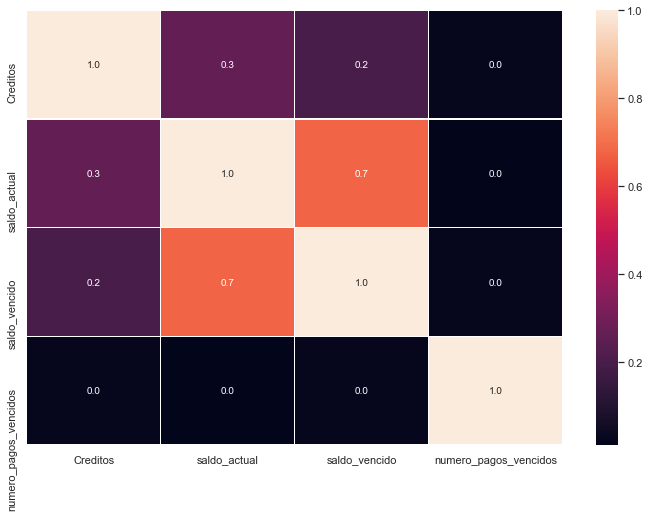

In [18]:
credit_type_columns = ['Creditos', 'saldo_actual', 'saldo_vencido', 'numero_pagos_vencidos']

f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(features_df[credit_type_columns].corr(method='pearson'), fmt=".1f", linewidths=.5, ax=ax, annot=True)

Claramente se aprecia que algunas variables tienen relación, pero no se tomarán decisiones hasta evaluar el impacto de estas. Procedamos entonces a definir las reglas de imputación:

- saldo_actual y saldo_vencido: se realiza imputación para valores missing con cero (0).

- numero_pagos_vencidos: dada su distribución asimétrica a la derecha, con una mediana de 1, media de 16.1 y un porcentaje de valores perdidos de 60.7%, la consideración de imputar este valor con una medida de tendencia central probablemente intruduzca sesgos o sobreajuste en el modelado. La única es imputar con cero (0), asumiendo que los usuarios con este valor nulo simplemente no tienen pagos vencidos.

In [19]:
missing_others = ['numero_pagos_vencidos']

missing_columns = missing_columns + missing_others
for col in missing_others:
    no_missing_columns.pop(no_missing_columns.index(col))

print(f"Cantidad de columnas seleccionadas missing: {len(missing_columns)}")
print(f"Cantidad de columnas seleccionadas no missing: {len(no_missing_columns)}")

Cantidad de columnas seleccionadas missing: 50
Cantidad de columnas seleccionadas no missing: 30


#### Análisis variables tipo "promedio" en la muestra

| Columna                      | Tipo de dato | % nulos | # nulos |
|:-----------------------------|:-------------|:--------|:--------|
| Promedio de limite_credito   | flotante     | 37.2%   | 1076    |
| Promedio de credito_maximo   | flotante     | 0.3%    | 8       |
| Promedio de cantidad_cuotas  | flotante     | 10.3%   | 297     |
| Promedio de valor_cuota      | flotante     | 0.1%    | 3       |

Antes que nada vamos a analizar si estas variables tienen algún tipo de relación entre ellas.

<AxesSubplot:>

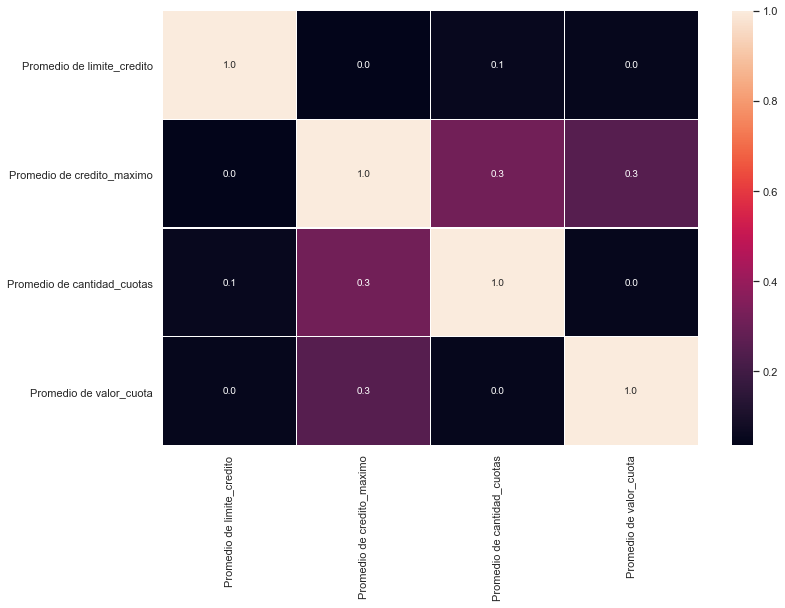

In [20]:
avg_type_columns = ['Promedio de limite_credito', 'Promedio de credito_maximo', 'Promedio de cantidad_cuotas', 'Promedio de valor_cuota']

f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(features_df[avg_type_columns].corr(method='pearson'), fmt=".1f", linewidths=.5, ax=ax, annot=True)

Claramente se aprecia que las variables no tienen ninguna relación. Procedamos entonces a definir las reglas de imputación de valores missing:

- Promedio de credito_maximo y Promedio de valor_cuota: tanto los valores en -1 como los valores missing serán imputados con el valor cero (0).

- Promedio de limite_credito: esta variable tiene un porcentaje de valores en cero de 48.7%, con un valor de **mediana** que es cero (0), por tanto, los valores missing serán imputados con este mismo valor.

- Promedio de cantidad_cuotas: según la distribución, tiene una cola pesada a la derecha con sesgo de 12.5. En este caso es mejor imputar con una medida de tendencia central tolerante a los valores atípicos: **mediana**. Esta tiene un valor de **3.2**.

#### Análisis de variables tipo "ahorro" en la muestra

| Columna                      | Tipo de dato | % nulos | # nulos |
|:-----------------------------|:-------------|:--------|:--------|
| Tiene_ahorro                 | entero       | 0.0%    | 0       |
| monto_ahorro                 | flotante     | 0.0%    | 0       |
| monto_bloqueado              | flotante     | 2.0%    | 58      |
| monto_total                  | flotante     | 2.0%    | 58      |

Vamos a analizar si estas variables tienen algún tipo de relación entre ellas.

<AxesSubplot:>

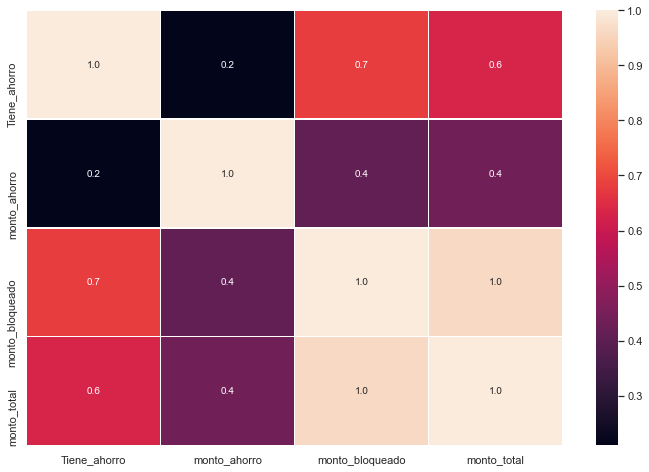

In [21]:
amount_type_columns = ['Tiene_ahorro', 'monto_ahorro', 'monto_bloqueado', 'monto_total']

f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(features_df[amount_type_columns].corr(method='pearson'), fmt=".1f", linewidths=.5, ax=ax, annot=True)

Vemos como el **monto_bloqueado** y **monto_total** tienen un factor de correlación del 100%. No se tomaran decisiones de eliminación hasta no estudiar el impacto del monto de ahorro bloqueado cuando se evalúa ingreso al programa de reparación.

Realizaremos un estudio adicional de **Tiene_ahorro** vs. **monto_total**, ya que se aprecia un factor de correlación del 60%.

<AxesSubplot:xlabel='Tiene_ahorro', ylabel='monto_total'>

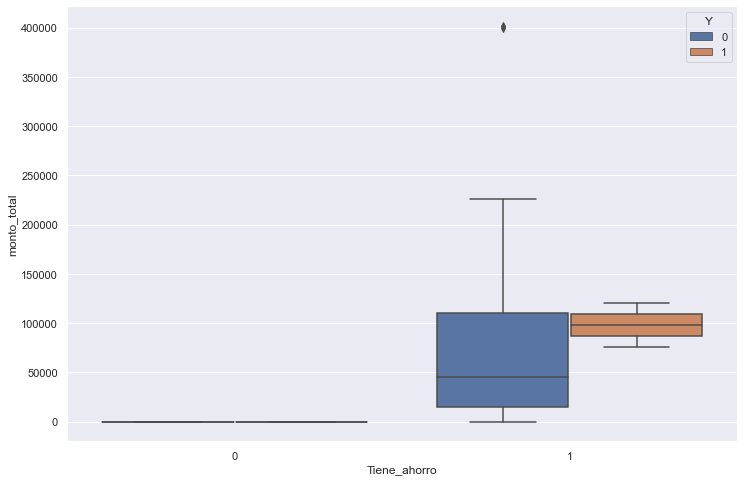

In [23]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(x=features_df['Tiene_ahorro'], y=features_df['monto_total'], hue=target)

Finalmente, dado que los valores missing de **monto_total y monto_bloqueado** son apenas **58 registros**, vamos a imputar esta variable con un cero (0).

#### Análisis de variables producto "comunicaciones" en la muestra

| Columna                      | Tipo de dato | % nulos | # nulos |
|:-----------------------------|:-------------|:--------|:--------|
| Comunicaciones_saldo_actual  | flotante     | 21.8%   | 632     |
| Comunicaciones_saldo_vencido | flotante     | 21.8%   | 632     |
| %_comunicaciones             | flotante     | 23.5%   | 680     |
| Comunicaciones_garantia      | entero       | 21.2%   | 614     |


Vamos a analizar si estas variables tienen algún tipo de relación entre ellas.

<AxesSubplot:>

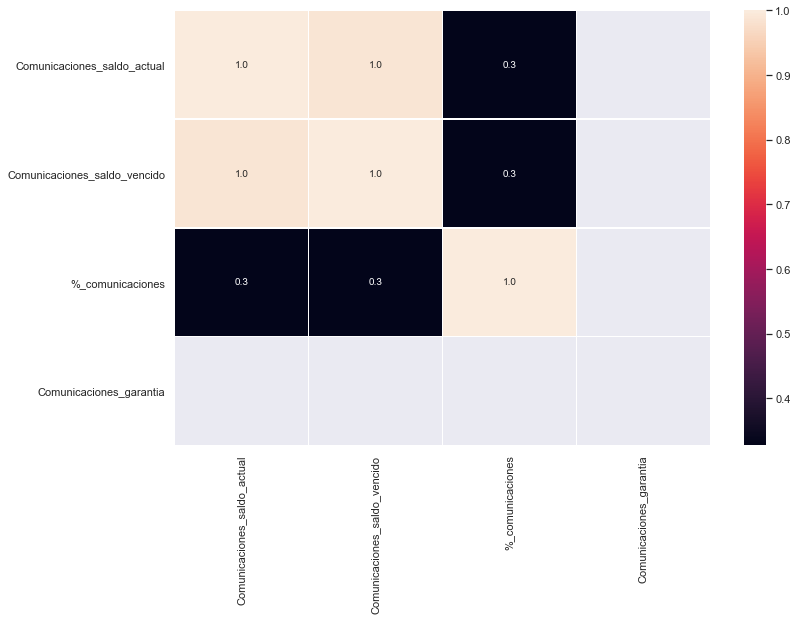

In [24]:
comm_type_columns = ['Comunicaciones_saldo_actual', 'Comunicaciones_saldo_vencido', '%_comunicaciones', 'Comunicaciones_garantia']

f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(features_df[comm_type_columns].corr(method='pearson'), fmt=".1f", linewidths=.5, ax=ax, annot=True)

Claramente se aprecia que algunas variables tienen relación, por lo tanto, para efectos del modelado vamos a eliminar **Comunicaciones_saldo_vencido** dada la fuerte corelación con **Comunicaciones_saldo_actual**:

- Comunicaciones_saldo_actual, %_comunicaciones y Comunicaciones_garantia: se realiza imputación para valores missing con cero (0).

In [25]:
missing_others = ['Comunicaciones_saldo_vencido']

missing_columns = missing_columns + missing_others
for col in missing_others:
    no_missing_columns.pop(no_missing_columns.index(col))

print(f"Cantidad de columnas seleccionadas missing: {len(missing_columns)}")
print(f"Cantidad de columnas seleccionadas no missing: {len(no_missing_columns)}")

Cantidad de columnas seleccionadas missing: 51
Cantidad de columnas seleccionadas no missing: 29


#### Análisis de variables tipo "consumo" en la muestra

| Columna                      | Tipo de dato | % nulos | # nulos |
|:-----------------------------|:-------------|:--------|:--------|
| Consumo_saldo_actual         | flotante     | 37.9%   | 1098    |
| Consumo_saldo_vencido        | flotante     | 37.9%   | 1098    |
| %_consumo                    | flotante     | 38.7%   | 1120    |
| consumo_garantia             | entero       | 37.1%   | 1074    |

Vamos a analizar si estas variables tienen algún tipo de relación entre ellas.

<AxesSubplot:>

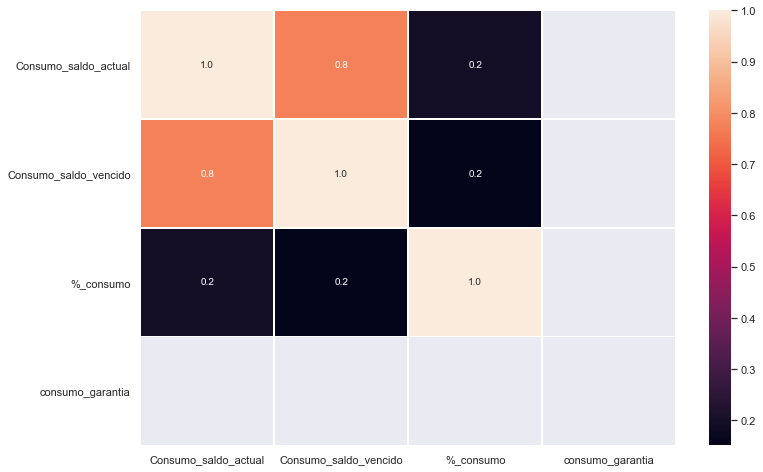

In [26]:
cons_type_columns = ['Consumo_saldo_actual', 'Consumo_saldo_vencido', '%_consumo', 'consumo_garantia']

f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(features_df[cons_type_columns].corr(method='pearson'), fmt=".1f", linewidths=.5, ax=ax, annot=True)

Claramente se aprecia que algunas variables tienen relación, por lo tanto, para efectos del modelado vamos a eliminar **Consumo_saldo_vencido** dada la fuerte corelación con **Consumo_saldo_actual**:

- Consumo_saldo_actual, %_consumo y consumo_garantia: se realiza imputación para valores missing con cero (0).

In [27]:
missing_others = ['Consumo_saldo_vencido']

missing_columns = missing_columns + missing_others
for col in missing_others:
    no_missing_columns.pop(no_missing_columns.index(col))

print(f"Cantidad de columnas seleccionadas missing: {len(missing_columns)}")
print(f"Cantidad de columnas seleccionadas no missing: {len(no_missing_columns)}")

Cantidad de columnas seleccionadas missing: 52
Cantidad de columnas seleccionadas no missing: 28


### Análisis exploratorio de datos multivariado

A continuación, vamos a realizar análisis puntuales sobre combinaciones de características, buscando algunos patrones en los datos que nos permitan tomar decisiones para la limpieza, estandarización y preparación de los datos.

In [28]:
features_multi_df = features_df[no_missing_columns]
features_multi_df["Y"] = target

features_multi_df.columns.shape

(29,)

#### Análisis de variable objetivo con edad y genero

<AxesSubplot:xlabel='genero', ylabel='edad'>

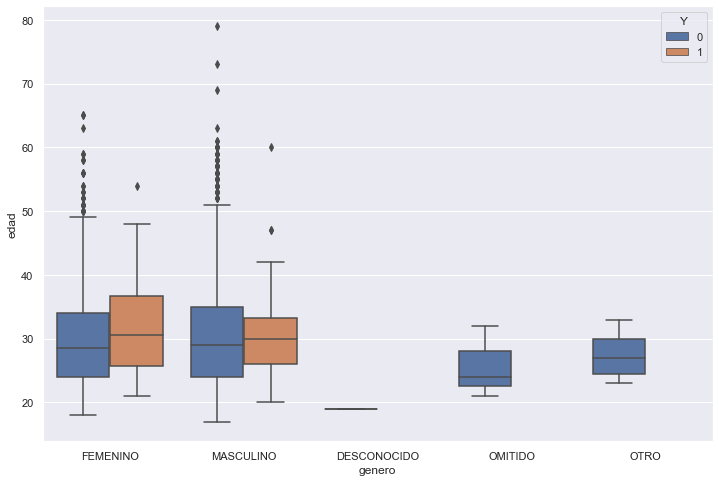

In [29]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=features_multi_df, x="genero", y="edad", hue="Y")

<AxesSubplot:xlabel='genero', ylabel='edad'>

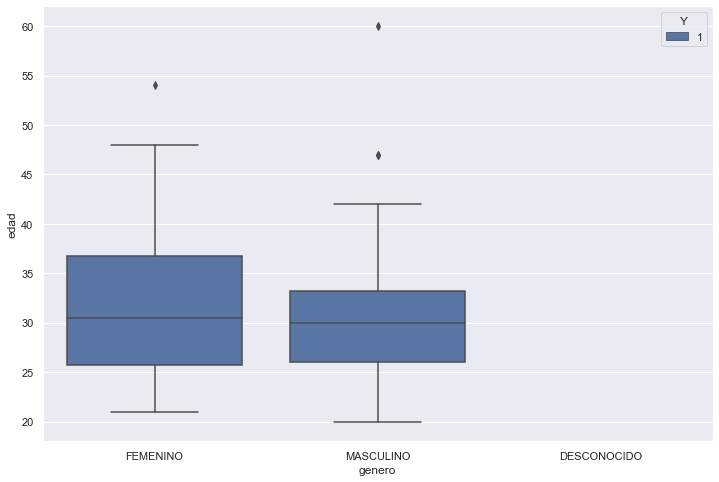

In [30]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=features_multi_df[features_multi_df.Y == 1], x="genero", y="edad", hue="Y")

Vemos que los casos de usuarios propensos a reparación se distribuyen exclusivamente en los generos **FEMENINO** y **MASCULINO**. La edad promedio para entrar al programa de reparación en ambos generos es **30 años** aproximadamente y es evidente como las mujeres tienen un rango de edad más amplio para ser marcadas como aceptado. Además, notese el rango de edades para aceptados entre 25 y 37 años aproximadamente.

Es fáctible que los otros generos se integren en **OTRO**, no justifica tenerlos dispersos. Por tanto, los valores **DESCONOCIDO** y **OMITIDO** serán modificados por el valor indicado **OTRO**.

Identificamos 3 rangos etáreos claros. Usuarios entre la edad mínima y los 25 años, de 25 a 37 años y de 37 en adelante. Podemos construir intencionalmente estos rangos y convertir la edad en una categórica o permitir que un método automático lo haga.

#### Análisis de variable objetivo con antiguedad, mop y score

<AxesSubplot:xlabel='Antiguedad', ylabel='score'>

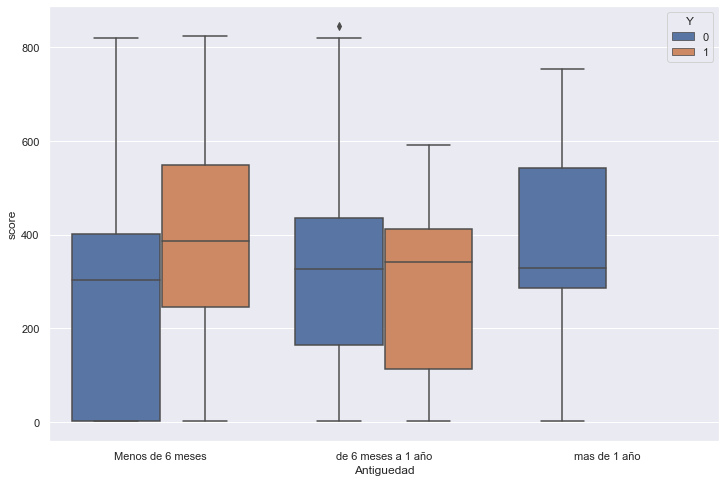

In [31]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=features_multi_df, x="Antiguedad", y="score", hue="Y")

Vemos en general que la mayoría de los usuarios que han sido evaluados para ingresar a reparación, no superan un score de **600 puntos**, lo cual indica que aquellos que buscan este programa necesitan alivios financieros. Justamente, los usuarios más antiguos que fueron aceptados tienen los score más bajos.

El valor de antiguedad "mas de 1 año" efectivamente puede integrarse con el valor "de 6 meses a 1 año" para efectos del modelado.

<AxesSubplot:xlabel='mop_historico', ylabel='score'>

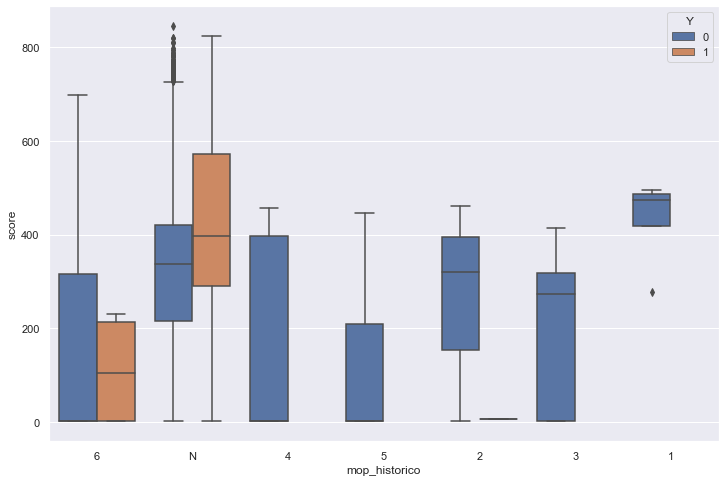

In [32]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=features_multi_df, x="mop_historico", y="score", hue="Y")

Notese como el score tiende a bajar cuando aumenta el MOP histórico, es decir, a medida que las personas acumulan días de mora, el score comienza a descender paulatinamente.

Vemos que usuarios aceptados y que se encuentran al día tienen los score promedio más altos, lo que indica que una persona con buen comportamiento tiene alta posibilidad de ingresar a reparación. Por otro lado, quienes tienen las deudas más atrasadas, en el MOP histórico mayor a 120 días, también tienen oportunidad de ingresar y son candidatos considerados por su bajo score crediticio.

Dado que algunos valores de MOP histórico no tienen lugar en la decisión de ser aceptado o rechazado, vamos a integrar los MOP con valor 1, 2, 3, 4 en un único rango llamado "Mora 30 a 120 días".

#### Análisis de variable objetivo con saldo actual, saldo vencido y nro pagos vencidos

<AxesSubplot:xlabel='saldo_actual', ylabel='saldo_vencido'>

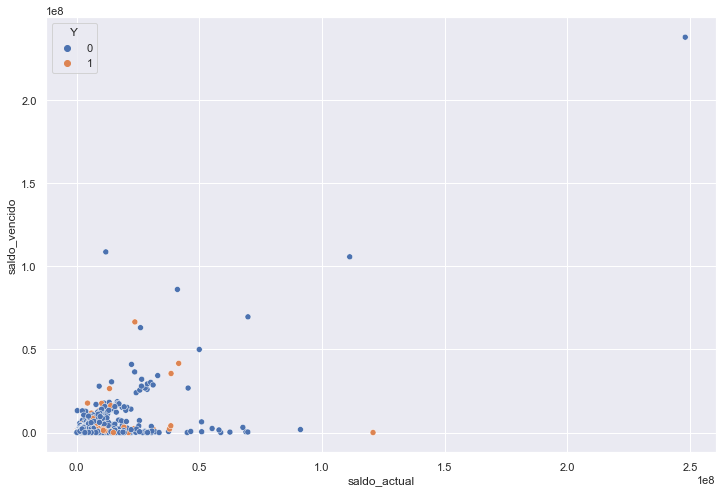

In [33]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=features_multi_df, x="saldo_actual", y="saldo_vencido", hue="Y")

No se evidencia un patron de decisión con el saldo actual y vencido. Uno pensaría que las personas propensas a entrar al programa tienen el valor de saldo y cantidad de pagos vencidos más altos, pero no se evidencia claramente. Vamos a estudiarlos individualmente usando el mop histórico.

<AxesSubplot:xlabel='mop_historico', ylabel='saldo_actual'>

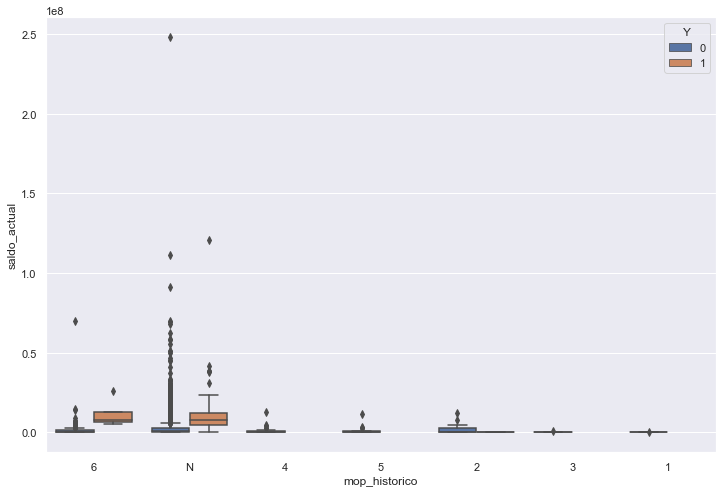

In [34]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=features_multi_df, x="mop_historico", y="saldo_actual", hue="Y")

<AxesSubplot:xlabel='mop_historico', ylabel='saldo_vencido'>

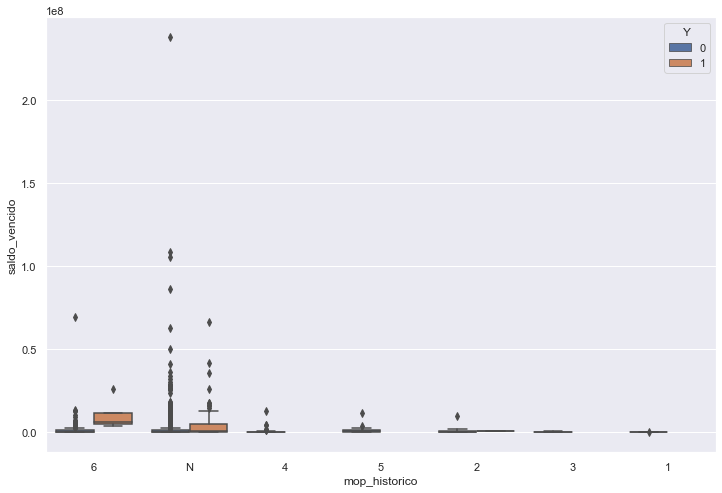

In [35]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=features_multi_df, x="mop_historico", y="saldo_vencido", hue="Y")

Notese como el saldo actual y vencido tienen valores promedio más altos para las usuarios que fueron aceptados en reparación. Por tanto, estas variables son muy importantes para el modelado.

#### Análisis variable objetivo con promedio límite crédito y crédito máximo

<AxesSubplot:xlabel='Promedio de limite_credito', ylabel='Promedio de credito_maximo'>

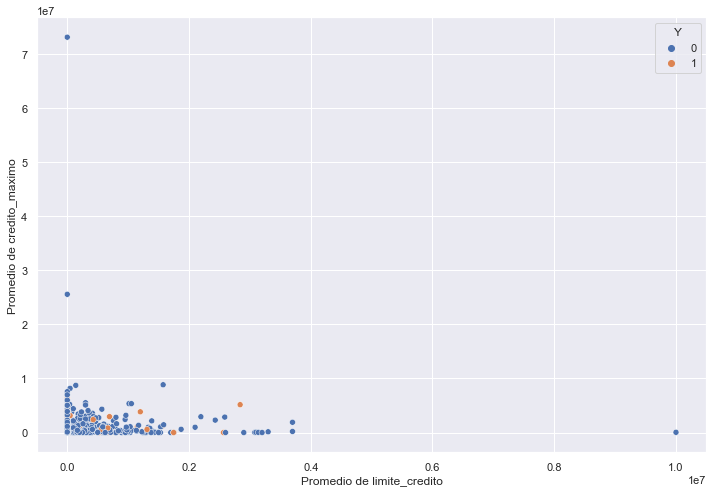

In [36]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=features_multi_df, x="Promedio de limite_credito", y="Promedio de credito_maximo", hue="Y")

<AxesSubplot:xlabel='mop_historico', ylabel='Promedio de limite_credito'>

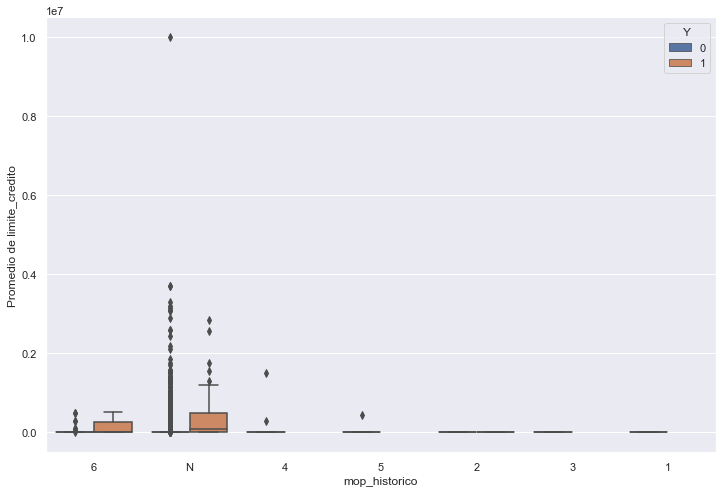

In [37]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=features_multi_df, x="mop_historico", y="Promedio de limite_credito", hue="Y")

<AxesSubplot:xlabel='mop_historico', ylabel='Promedio de credito_maximo'>

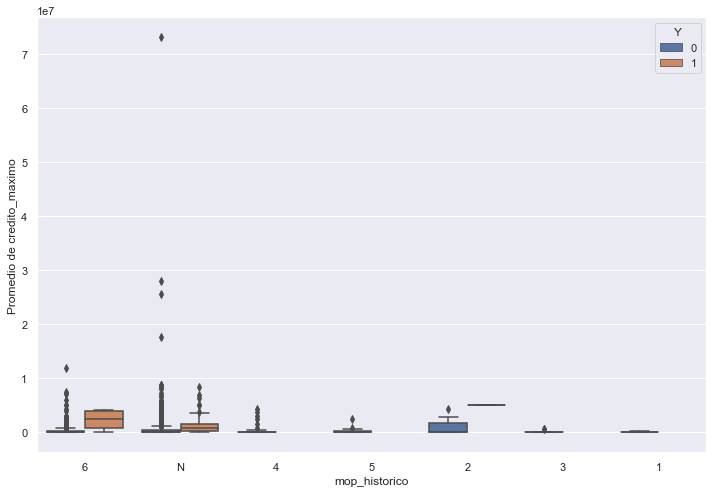

In [38]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=features_multi_df, x="mop_historico", y="Promedio de credito_maximo", hue="Y")

Notese que los valores más altos de estos promedios son para los usuarios aceptados. En efecto, estas variables se seguiran considerando en el modelado y se consideraran como de alta relevancia.

#### Análisis variable objetivo con promedio cantidad y valor de cuota

<AxesSubplot:xlabel='Promedio de cantidad_cuotas', ylabel='Promedio de valor_cuota'>

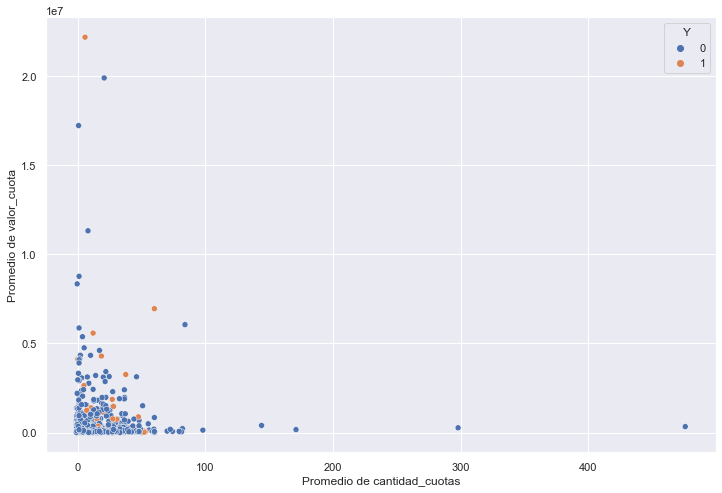

In [39]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=features_multi_df, x="Promedio de cantidad_cuotas", y="Promedio de valor_cuota", hue="Y")

<AxesSubplot:xlabel='mop_historico', ylabel='Promedio de cantidad_cuotas'>

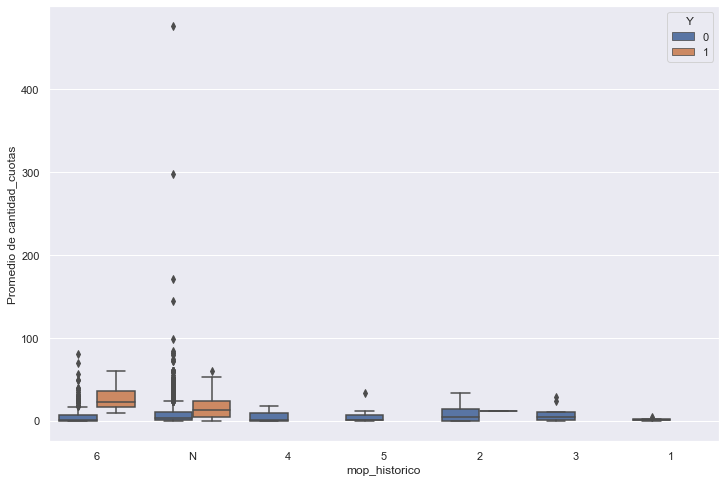

In [40]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=features_multi_df, x="mop_historico", y="Promedio de cantidad_cuotas", hue="Y")

<AxesSubplot:xlabel='mop_historico', ylabel='Promedio de valor_cuota'>

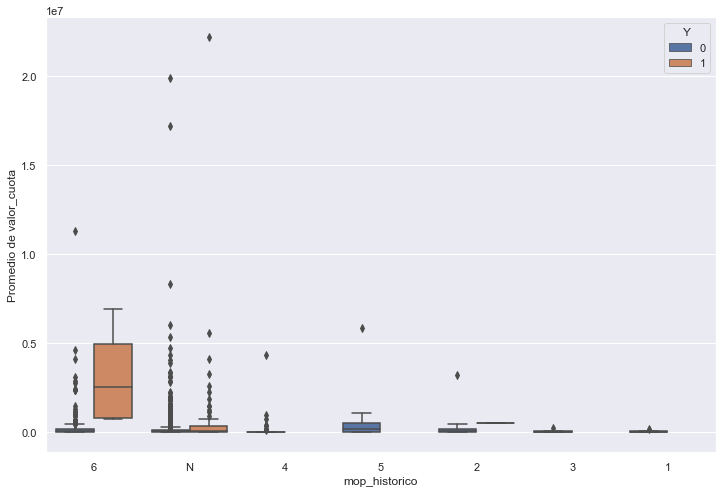

In [41]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=features_multi_df, x="mop_historico", y="Promedio de valor_cuota", hue="Y")

Efectivamente, estas variables influyen mucho en el modelado. Notese como los usuarios que ingresan al programa tienen valores más altos en la cantidad y valor promedio de cuotas. Tienen relevancia alta para el modelo.

#### Análisis variable objetivo con monto ahorro, bloqueado y total

<AxesSubplot:xlabel='monto_ahorro', ylabel='monto_total'>

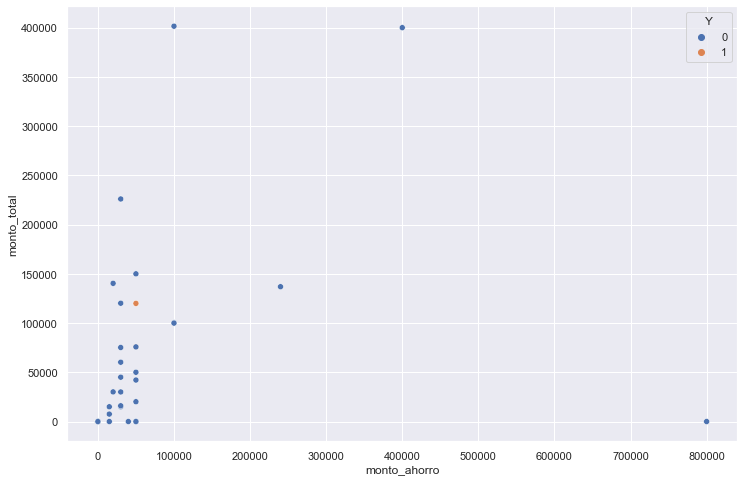

In [42]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=features_multi_df, x="monto_ahorro", y="monto_total", hue="Y")

<AxesSubplot:xlabel='monto_bloqueado', ylabel='monto_total'>

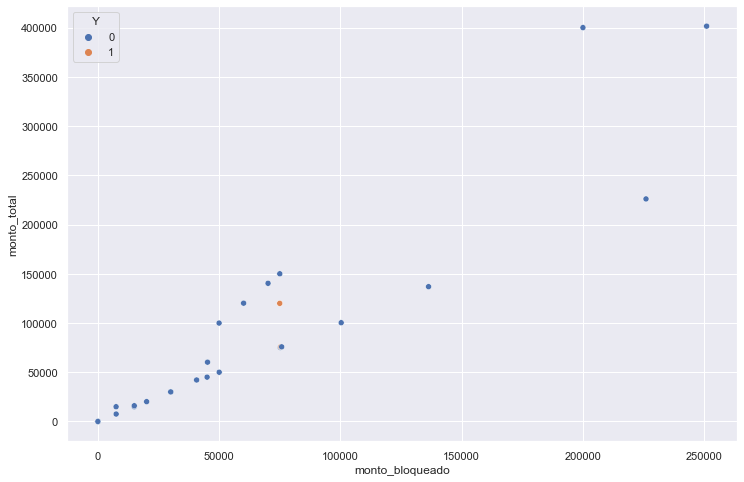

In [43]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=features_multi_df, x="monto_bloqueado", y="monto_total", hue="Y")

<AxesSubplot:xlabel='Tiene_ahorro', ylabel='monto_ahorro'>

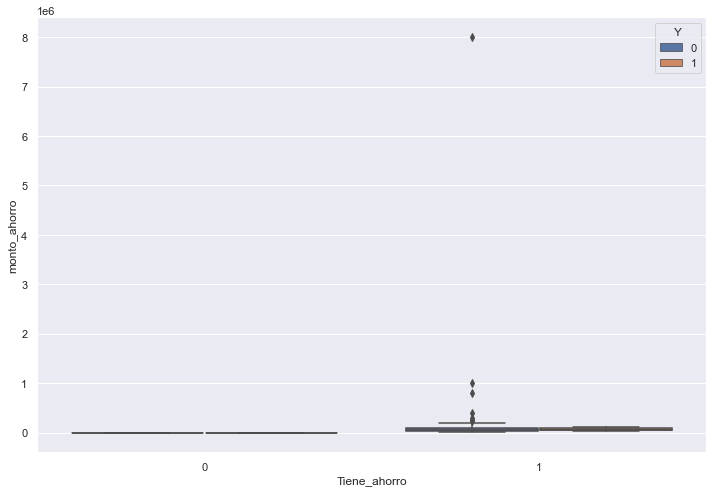

In [44]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=features_multi_df, x="Tiene_ahorro", y="monto_ahorro", hue="Y")

<AxesSubplot:xlabel='Tiene_ahorro', ylabel='monto_total'>

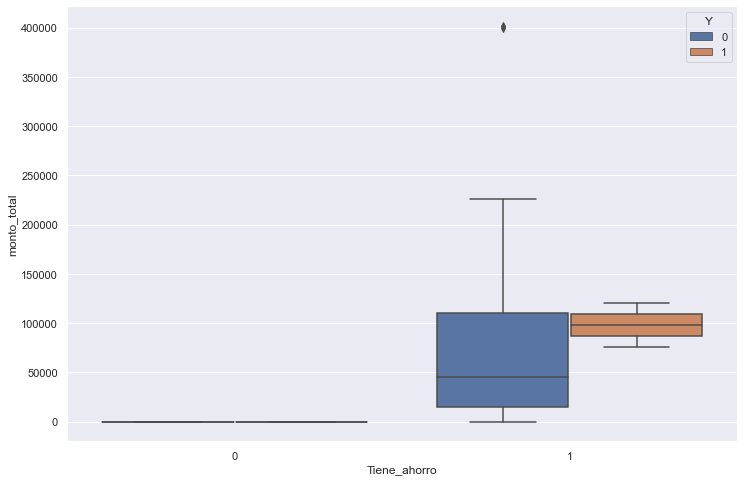

In [45]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=features_multi_df, x="Tiene_ahorro", y="monto_total", hue="Y")

Podemos apreciar que monto_ahorro no tiene relación con monto_bloqueado y monto_total. Estas dos últimas si tienen una estrecha relación lineal y por tanto, vamos a considerar para modelado **monto_total** y se eliminará **monto_bloqueado**.

El análisis indica que los usuarios tienen más probabilidad de entrar al programa si tienen un valor de ahorro, por tanto **Tiene_ahorro**, **monto_ahorro** y **monto_total** agregan el comportamiento necesario en el modelado.

In [46]:
missing_others = ['monto_bloqueado']

missing_columns = missing_columns + missing_others
for col in missing_others:
    no_missing_columns.pop(no_missing_columns.index(col))

print(f"Cantidad de columnas seleccionadas missing: {len(missing_columns)}")
print(f"Cantidad de columnas seleccionadas no missing: {len(no_missing_columns)}")

Cantidad de columnas seleccionadas missing: 53
Cantidad de columnas seleccionadas no missing: 27


#### Análisis variable objetivo con producto "Comunicaciones"

In [47]:
# Imputamos cero en variables para efecto del análisis
features_multi_df['Comunicaciones_saldo_actual'] = features_multi_df['Comunicaciones_saldo_actual'].fillna(0)
features_multi_df['%_comunicaciones'] = features_multi_df['%_comunicaciones'].fillna(0)
features_multi_df['Comunicaciones_garantia'] = features_multi_df['Comunicaciones_garantia'].fillna(0)

<AxesSubplot:xlabel='Comunicaciones_saldo_actual', ylabel='%_comunicaciones'>

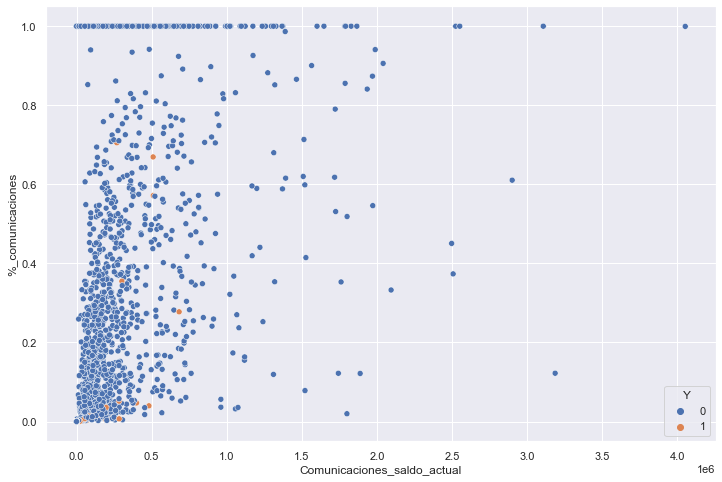

In [48]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=features_multi_df, x="Comunicaciones_saldo_actual", y="%_comunicaciones", hue="Y")

<AxesSubplot:xlabel='Comunicaciones_garantia', ylabel='Comunicaciones_saldo_actual'>

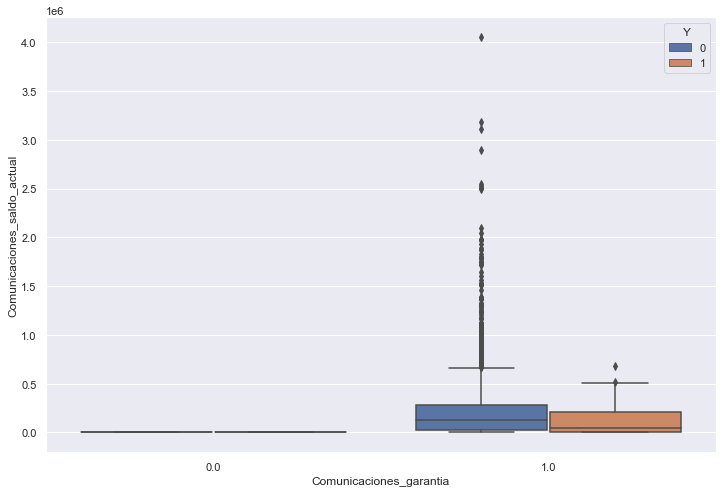

In [49]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=features_multi_df, x="Comunicaciones_garantia", y="Comunicaciones_saldo_actual", hue="Y")

<AxesSubplot:xlabel='Comunicaciones_garantia', ylabel='%_comunicaciones'>

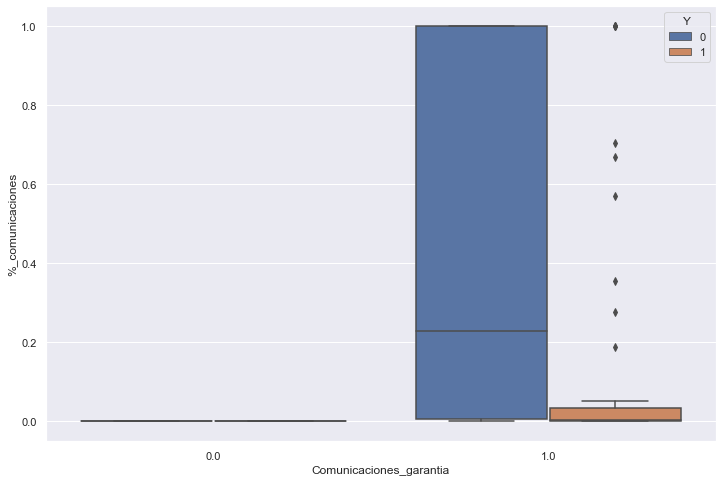

In [50]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=features_multi_df, x="Comunicaciones_garantia", y="%_comunicaciones", hue="Y")

Notese como los usuarios aceptados y que cuentan con el producto **Comunicaciones** tienen garantía activada. Por otro lado, se intuye que quienes no tienen el producto no se ven afectados por la variable **Comunicaciones_garantia**, por lo tanto procederemos a eliminarla.

In [51]:
missing_others = ['Comunicaciones_garantia']

missing_columns = missing_columns + missing_others
for col in missing_others:
    no_missing_columns.pop(no_missing_columns.index(col))

print(f"Cantidad de columnas seleccionadas missing: {len(missing_columns)}")
print(f"Cantidad de columnas seleccionadas no missing: {len(no_missing_columns)}")

Cantidad de columnas seleccionadas missing: 54
Cantidad de columnas seleccionadas no missing: 26


<AxesSubplot:xlabel='mop_historico', ylabel='Comunicaciones_saldo_actual'>

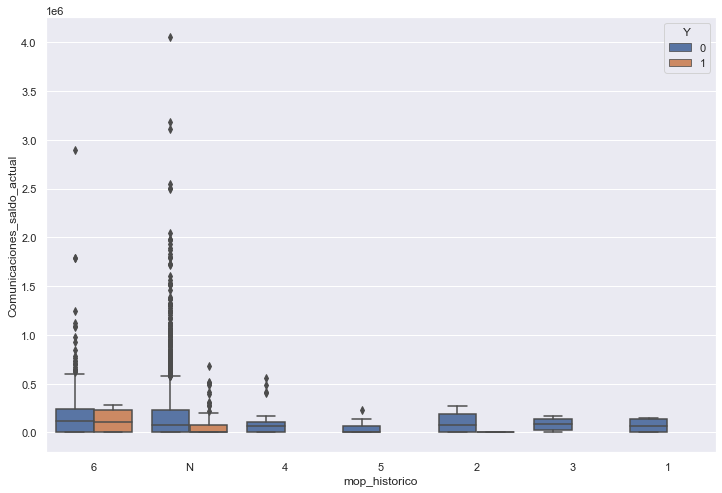

In [52]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=features_multi_df, x="mop_historico", y="Comunicaciones_saldo_actual", hue="Y")

<AxesSubplot:xlabel='mop_historico', ylabel='%_comunicaciones'>

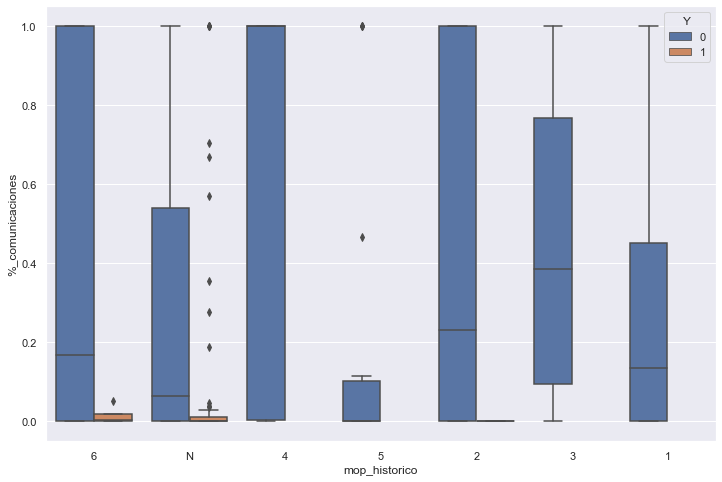

In [53]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=features_multi_df, x="mop_historico", y="%_comunicaciones", hue="Y")

Lo primero es que estas variables no tienen una incidencia clara sobre la decisión de aceptar o rechazar un usuario. Hay un comportamiento equilibrado. Sin embargo, las vamos a conservar y evaluar en la **selección de características**.

#### Análisis variable objetivo con producto "Consumo"

In [54]:
# Imputamos cero en variables para efecto del análisis
features_multi_df['Consumo_saldo_actual'] = features_multi_df['Consumo_saldo_actual'].fillna(0)
features_multi_df['%_consumo'] = features_multi_df['%_consumo'].fillna(0)
features_multi_df['consumo_garantia'] = features_multi_df['consumo_garantia'].fillna(0)

<AxesSubplot:xlabel='Consumo_saldo_actual', ylabel='%_consumo'>

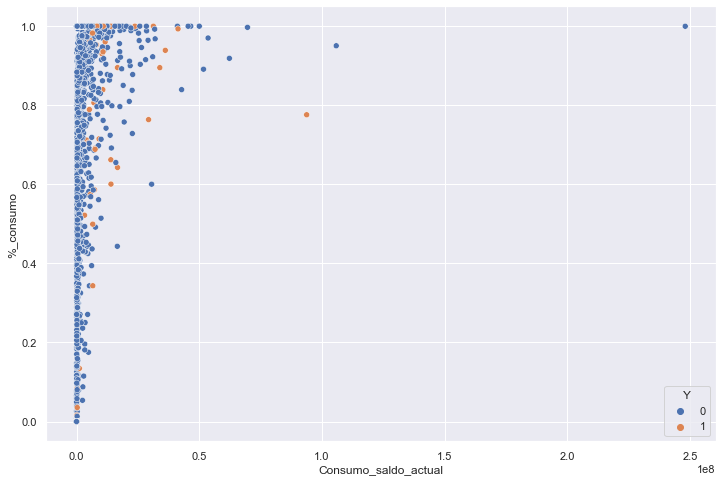

In [55]:
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=features_multi_df, x="Consumo_saldo_actual", y="%_consumo", hue="Y")

<AxesSubplot:xlabel='consumo_garantia', ylabel='Consumo_saldo_actual'>

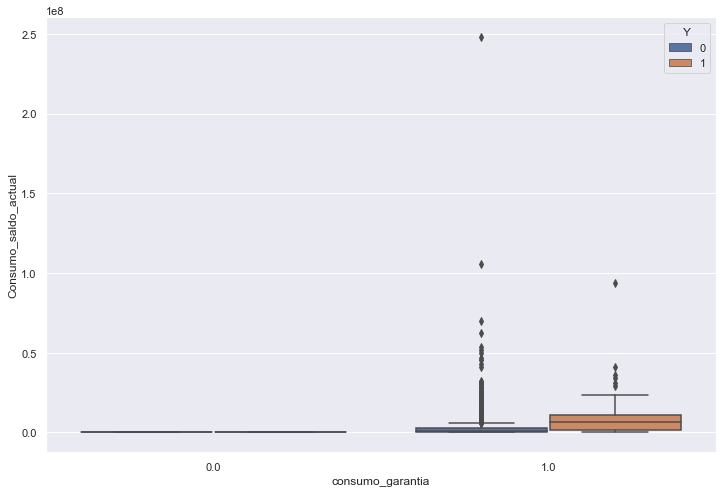

In [56]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=features_multi_df, x="consumo_garantia", y="Consumo_saldo_actual", hue="Y")

<AxesSubplot:xlabel='consumo_garantia', ylabel='%_consumo'>

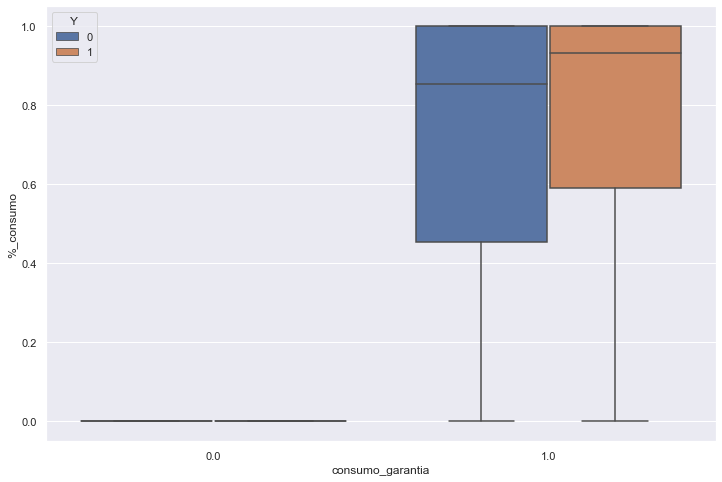

In [57]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=features_multi_df, x="consumo_garantia", y="%_consumo", hue="Y")

Notese como los usuarios aceptados y que cuentan con el producto **Consumo** tienen garantía activada. Por otro lado, se intuye que quienes no tienen el producto no se ven afectados por la variable **consumo_garantia**, por lo tanto procederemos a eliminarla.

In [58]:
missing_others = ['consumo_garantia']

missing_columns = missing_columns + missing_others
for col in missing_others:
    no_missing_columns.pop(no_missing_columns.index(col))

print(f"Cantidad de columnas seleccionadas missing: {len(missing_columns)}")
print(f"Cantidad de columnas seleccionadas no missing: {len(no_missing_columns)}")

Cantidad de columnas seleccionadas missing: 55
Cantidad de columnas seleccionadas no missing: 25


<AxesSubplot:xlabel='mop_historico', ylabel='Consumo_saldo_actual'>

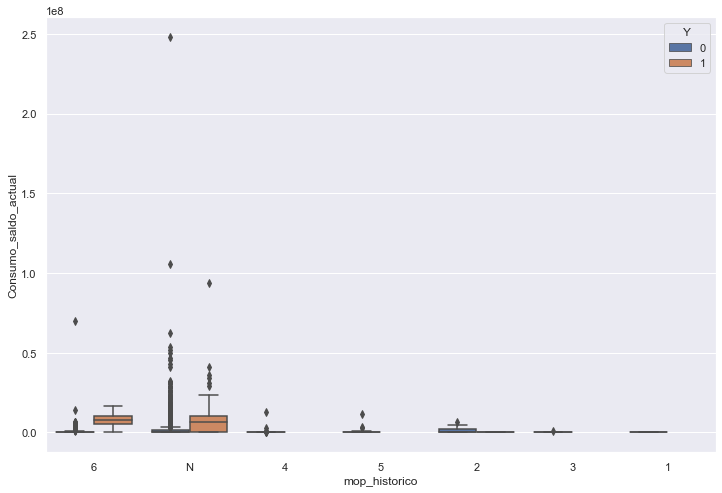

In [59]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=features_multi_df, x="mop_historico", y="Consumo_saldo_actual", hue="Y")

<AxesSubplot:xlabel='mop_historico', ylabel='%_consumo'>

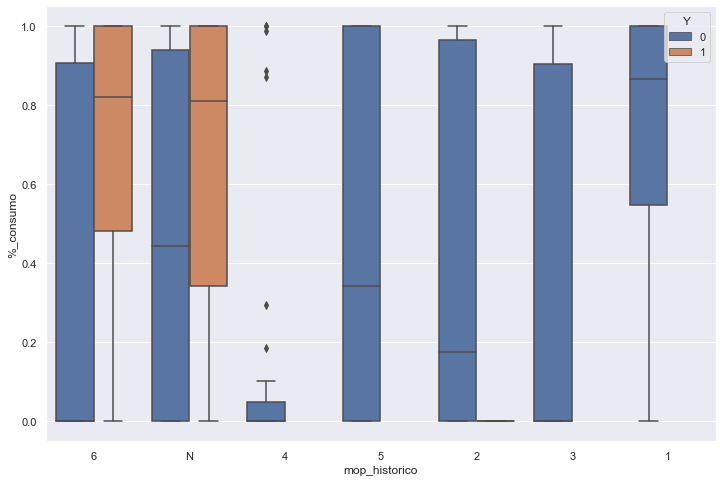

In [60]:
f, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=features_multi_df, x="mop_historico", y="%_consumo", hue="Y")

Lo primero es que estas variables no tienen una incidencia clara sobre la decisión de aceptar o rechazar un usuario. Hay un comportamiento equilibrado. Sin embargo, las vamos a conservar y evaluar en la **selección de características**.

##  2. Ingeniería de características

### Limpieza de los datos

In [61]:
# Columnnas a conservar en el conjunto de datos original
with open('output/columns_no_missing.pkl', 'wb') as f:
    pickle.dump(no_missing_columns, f)

print(no_missing_columns)

['edad', 'genero', 'Antiguedad', 'Creditos', 'saldo_actual', 'saldo_vencido', 'mop_historico', 'Promedio de limite_credito', 'Promedio de credito_maximo', 'Promedio de cantidad_cuotas', 'Promedio de valor_cuota', 'ahorro_impacto', 'bienestar_financiero_impacto', 'coaching_impacto', 'score', 'Tiene_ahorro', 'monto_ahorro', 'monto_total', 'Comunicaciones_saldo_actual', '%_comunicaciones', 'Comunicaciones_pagos_vencidos', 'Consumo_saldo_actual', '%_consumo', 'consumo_pagos_vencidos', 'Garantia']


In [62]:
# Copia del conjunto de datos original
clean_df = df.copy()

# Eliminamos las características que no serán requeridas
clean_df = clean_df[no_missing_columns]
clean_df.shape

(2896, 25)

In [63]:
# Reemplazamos valores negativos en características numéricas por NULO
# y luego los valores nulos por cero (0)

types_temp = clean_df.dtypes.astype(str)
columns_temp = types_temp[types_temp.isin(['int64', 'float64'])].index.tolist()
columns_temp_zeros = [i for i in columns_temp if i not in ['edad', 'Promedio de cantidad_cuotas']]

for column in columns_temp:
    clean_df[column] = clean_df[column].apply(lambda x: np.nan if x < 0 else x)
    
for column in columns_temp_zeros:
    clean_df[column] = clean_df[column].fillna(0)

clean_df[columns_temp].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
edad,"2,718.00",30.54,8.30,17.00,24.00,29.00,35.00,79.00
Creditos,"2,896.00",6.03,7.12,1.00,3.00,4.00,7.00,121.00
saldo_actual,"2,896.00","2,932,009.28","8,291,931.55",0.00,"279,750.00","756,499.50","2,422,000.00","248,019,008.00"
saldo_vencido,"2,896.00","1,735,881.52","6,784,135.51",0.00,"161,750.00","469,000.00","1,267,000.00","238,035,008.00"
Promedio de limite_credito,"2,896.00","71,727.59","341,069.31",0.00,0.00,0.00,0.00,"10,000,000.00"
Promedio de credito_maximo,"2,896.00","545,288.23","1,847,656.72",0.00,0.00,"119,708.50","514,305.25","73,152,128.00"
Promedio de cantidad_cuotas,"2,205.00",9.56,17.38,0.00,1.00,4.50,12.00,476.00
Promedio de valor_cuota,"2,896.00","215,527.93","854,530.29",0.00,"19,333.00","58,243.00","149,208.50","22,200,000.00"
ahorro_impacto,"2,896.00",0.01,0.11,0.00,0.00,0.00,0.00,1.00
bienestar_financiero_impacto,"2,896.00",0.00,0.03,0.00,0.00,0.00,0.00,1.00


### Imputación de datos

#### Edad

Reemplazamos los valores nulos de edad por el valor de la **media**.

In [68]:
age_imputer = int(round(df['edad'].mean(), 0))
age_imputer

31

In [65]:
clean_df['edad'] = clean_df['edad'].fillna(age_imputer)
(~clean_df['edad'].isna()).sum()

2896

#### Promedio de cantidad_cuotas

Reemplazamos los valores nulos de Promedio de cantidad_cuotas por el valor de la **mediana**.

In [67]:
amount_fees_imputer = df['Promedio de cantidad_cuotas'].describe()['50%']
amount_fees_imputer

3.2

In [69]:
clean_df['Promedio de cantidad_cuotas'] = clean_df['Promedio de cantidad_cuotas'].fillna(amount_fees_imputer)
(~clean_df['Promedio de cantidad_cuotas'].isna()).sum()

2896

### Construcción de características

In [70]:
build_df = clean_df.copy()

#### Variable Genero

Vamos a agrupar valores de **Genero** que no influyen directamente en el modelado en un solo valor. Las categorías que se mantienen son **FEMENINO**, **MASCULINO** Y **OTRO**.

Convertiremos **DESCONOCIDO** y **OMITIDO** en **OTRO**

In [72]:
df.genero.value_counts()

MASCULINO      1814
FEMENINO        953
DESCONOCIDO     122
OTRO              4
OMITIDO           3
Name: genero, dtype: int64

In [73]:
genero_map = {
    'MASCULINO': 'MASCULINO',
    'FEMENINO': 'FEMENINO',
    'OTRO': 'OTRO',
    'DESCONOCIDO': 'OTRO',
    'OMITIDO': 'OTRO',
}
genero_map

{'MASCULINO': 'MASCULINO',
 'FEMENINO': 'FEMENINO',
 'OTRO': 'OTRO',
 'DESCONOCIDO': 'OTRO',
 'OMITIDO': 'OTRO'}

In [74]:
build_df['genero'] = build_df['genero'].map(genero_map)
build_df['genero'].value_counts()

MASCULINO    1814
FEMENINO      953
OTRO          129
Name: genero, dtype: int64

#### Variable Rango Etáreo

Dado que la edad es un valor entero discreto, su representación numérica no tiene un aporte directo en el modelado ya que es una categorización de los usuarios y no un valor numérico. Por tanto, procederemos a convertir la **edad** en una variable categórica, usando para ello rangos etáreos con base en su distribución. Tengamos en cuenta la regla definida en pasos anteriores (hasta 3 grupos etáreos):
- [Edad mínima, 25 años)
- [25 años, 37 años)
- [37 años, Edad máxima)

In [75]:
build_df['edad'].describe()

count   2,896.00
mean       30.57
std         8.04
min        17.00
25%        25.00
50%        29.00
75%        34.00
max        79.00
Name: edad, dtype: float64

<AxesSubplot:>

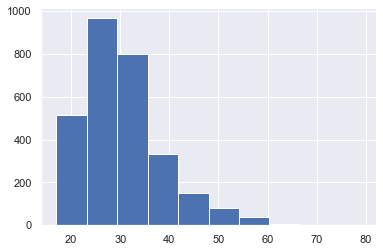

In [76]:
build_df['edad'].hist()

In [77]:
age_ranges = pd.qcut(build_df['edad'], 3)
age_ranges.unique().astype(str)

array(['(32.0, 79.0]', '(16.999, 26.0]', '(26.0, 32.0]'], dtype='<U14')

In [78]:
# Reemplazamos la variable "edad" por una categórica con "rangos de edad"
build_df['rango_edad'] = age_ranges.astype(str)
build_df['rango_edad'].value_counts()

(16.999, 26.0]    1017
(26.0, 32.0]      1000
(32.0, 79.0]       879
Name: rango_edad, dtype: int64

In [79]:
# Almacenamos los intervalos de edad
with open('output/age_ranges.pkl', 'wb') as f:
    pickle.dump(age_ranges.unique().tolist(), f)
    
# Eliminamos la columna edad
build_df = build_df.drop(columns=['edad'])

Esto lo hacemos dado que el comportamiento de endeudamiento cambia según la edad de las personas. Nótese el uso de pandas **qcut** para realizar este cálculo. Lo que hace es distribuir en categorías según los percentiles y nos da una interpretación más general de la edad.

#### Variable antiguedad

Tenemos actualmente los siguientes valores categóricos:
- Menos de 6 meses
- de 6 meses a 1 año
- mas de 1 año

Vamos a reemplazar **de 6 meses a 1 año** y **mas de 1 año** por **6 meses o mas**

In [80]:
build_df['Antiguedad'].value_counts()

Menos de 6 meses      2393
de 6 meses a 1 año     484
mas de 1 año            19
Name: Antiguedad, dtype: int64

In [81]:
antiquity_map = {
    'Menos de 6 meses': 'Menos de 6 meses',
    'de 6 meses a 1 año': '6 meses o mas',
    'mas de 1 año': '6 meses o mas',
}
antiquity_map

{'Menos de 6 meses': 'Menos de 6 meses',
 'de 6 meses a 1 año': '6 meses o mas',
 'mas de 1 año': '6 meses o mas'}

In [82]:
build_df['Antiguedad'] = build_df['Antiguedad'].map(antiquity_map)
build_df['Antiguedad'].value_counts()

Menos de 6 meses    2393
6 meses o mas        503
Name: Antiguedad, dtype: int64

#### Variable MOP Historico

Los valores categóricos oficiales por los cuales se cambiaran son:
- Nulos: Sin registro
- N: Al día
- 1: Mora 30 días
- 2: Mora 60 días
- 3: Mora 90 días
- 4: Mora 120 días
- 5, 6: Mora > 120 días

A pesar de lo anterior, vamos a agrupar según el análisis exploratorio, donde encontramos que solo dos categorías de MOP tienen valor en la decisión por tanto, vamos a generar una tercera para agrupar el resto de los datos:
- Nulos: Sin registro
- N: Al día
- 1, 2, 3, 4: Mora 30 a 120 días
- 5, 6: Mora > 120 días

In [83]:
build_df['mop_historico'].value_counts()

N    2282
6     359
4      34
5      18
2      13
3      11
1       4
Name: mop_historico, dtype: int64

In [84]:
mop_map = {
    'N': 'Al día',
    '1': 'Mora 30 a 120 días',
    '2': 'Mora 30 a 120 días',
    '3': 'Mora 30 a 120 días',
    '4': 'Mora 30 a 120 días',
    '5': 'Mora > 120 días',
    '6': 'Mora > 120 días',
}
mop_map

{'N': 'Al día',
 '1': 'Mora 30 a 120 días',
 '2': 'Mora 30 a 120 días',
 '3': 'Mora 30 a 120 días',
 '4': 'Mora 30 a 120 días',
 '5': 'Mora > 120 días',
 '6': 'Mora > 120 días'}

In [85]:
build_df['mop_historico'] = build_df['mop_historico'].map(mop_map)
build_df['mop_historico'] = build_df['mop_historico'].fillna('Sin registro')
build_df['mop_historico'].value_counts()

Al día                2282
Mora > 120 días        377
Sin registro           175
Mora 30 a 120 días      62
Name: mop_historico, dtype: int64

#### Variable perfil de usuario

Esta variable se calculará según el valor del **score**. A continuación se indican las transformaciones que se deben realizar a modo de rangos de score creditício:

- Nulos: Sin registro
- score = 1: Usuario en quiebra
- score = 7: Joven
- 150 <= score < 400: Bajo
- 400 <= score < 700: Medio
- 700 <= score < INF: Alto

[Referencia](https://qiip.com.co/es/blog/que-significa-tener-un-buen-puntaje-en-datacredito#:~:text=En%20Datacr%C3%A9dito%20el%20puntaje%20crediticio,de%20las%20obligaciones%20financieras%20pendientes)

<AxesSubplot:>

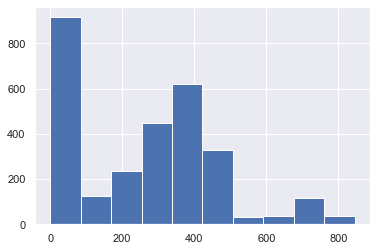

In [86]:
build_df['score'].hist()

In [87]:
def build_user_profile(value):
    if value == 1:
        return 'Usuario en quiebra'
    elif value == 7:
        return 'Joven'
    elif value >= 150 and value < 400:
        return 'Bajo'
    elif value >= 400 and value < 700:
        return 'Medio'
    elif value >= 700:
        return 'Alto'
    else:
        return 'Sin registro'
    
build_df['perfil_usuario'] = build_df['score'].apply(build_user_profile)
build_df['perfil_usuario'].value_counts()

Bajo                  1238
Usuario en quiebra     641
Medio                  613
Sin registro           246
Alto                   130
Joven                   28
Name: perfil_usuario, dtype: int64

In [88]:
build_df = build_df.drop(columns=['score'])

#### Variable Garantia

Vamos a convertir esta variable en catagoría así:

- 0: Sin garantia
- 1: Tipo garantia 1
- 2: Tipo garantia 2

In [89]:
build_df['Garantia'].value_counts()

2.00    2162
1.00     734
Name: Garantia, dtype: int64

In [90]:
garantia_map = {
    0.0: 'Sin garantia',
    1.0: 'Tipo garantia 1',
    2.0: 'Tipo garantia 2',
}
garantia_map

{0.0: 'Sin garantia', 1.0: 'Tipo garantia 1', 2.0: 'Tipo garantia 2'}

In [91]:
build_df['Garantia'] = build_df['Garantia'].map(garantia_map)
build_df['Garantia'] = build_df['Garantia'].fillna('Sin garantia')
build_df['Garantia'].value_counts()

Tipo garantia 2    2162
Tipo garantia 1     734
Name: Garantia, dtype: int64

### Verificación de los datos

In [92]:
target_column = ['Y']

types_temp = build_df.dtypes.astype(str)

categorical_columns = types_temp[types_temp.isin(['object'])].index.tolist()
numerical_columns = types_temp[types_temp.isin(['int64', 'float64'])].index.tolist()

In [93]:
len(categorical_columns + numerical_columns) == build_df.columns.shape[0]

True

Lo anterior certifica que la cantidad de variables previstas en los listados coincide con los datos en el objeto de pandas.

In [94]:
build_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   genero                         2896 non-null   object 
 1   Antiguedad                     2896 non-null   object 
 2   Creditos                       2896 non-null   int64  
 3   saldo_actual                   2896 non-null   float64
 4   saldo_vencido                  2896 non-null   float64
 5   mop_historico                  2896 non-null   object 
 6   Promedio de limite_credito     2896 non-null   float64
 7   Promedio de credito_maximo     2896 non-null   float64
 8   Promedio de cantidad_cuotas    2896 non-null   float64
 9   Promedio de valor_cuota        2896 non-null   float64
 10  ahorro_impacto                 2896 non-null   float64
 11  bienestar_financiero_impacto   2896 non-null   float64
 12  coaching_impacto               2896 non-null   f

In [95]:
temp_df = pd.DataFrame(build_df.isna().sum()).reset_index()
temp_df.columns = ['column', 'is_null']
temp_df[temp_df.is_null > 0].size

0

Concluímos que todas las variables han sido categorizadas correctamente y se han imputado valores para una fase de modelado adecuada. A continuación, vamos a analizar relaciones entre las variables, se realizará un proceso de selección de características y balanceo de datos con especial enfasis en la variable objetivo.

## 3. Selección de características y balanceo de datos

In [96]:
select_df = build_df.copy()

### Homologación tipos de datos

Realizaremos un proceso donde vamos a separar variables categóricas (representadas por cadenas de caracteres), variables enteras de representación booleana (0 y 1), variables enteras discretas y variables flotantes continuas. Esta distinción se hace especialmente para estudiar relaciones entre las variables, buscando identificar aquellas que "posiblemente" no tengan relevancia en el modelado.

In [97]:
print(numerical_columns)

['Creditos', 'saldo_actual', 'saldo_vencido', 'Promedio de limite_credito', 'Promedio de credito_maximo', 'Promedio de cantidad_cuotas', 'Promedio de valor_cuota', 'ahorro_impacto', 'bienestar_financiero_impacto', 'coaching_impacto', 'Tiene_ahorro', 'monto_ahorro', 'monto_total', 'Comunicaciones_saldo_actual', '%_comunicaciones', 'Comunicaciones_pagos_vencidos', 'Consumo_saldo_actual', '%_consumo', 'consumo_pagos_vencidos']


In [98]:
numeric_int_columns = ['Creditos', 'Promedio de cantidad_cuotas', 'ahorro_impacto', 'bienestar_financiero_impacto', 'coaching_impacto',
                       'Tiene_ahorro', 'Comunicaciones_pagos_vencidos', 'consumo_pagos_vencidos']

for i, column in enumerate(numeric_int_columns):
    select_df[column] = select_df[column].astype('int64')

select_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   genero                         2896 non-null   object 
 1   Antiguedad                     2896 non-null   object 
 2   Creditos                       2896 non-null   int64  
 3   saldo_actual                   2896 non-null   float64
 4   saldo_vencido                  2896 non-null   float64
 5   mop_historico                  2896 non-null   object 
 6   Promedio de limite_credito     2896 non-null   float64
 7   Promedio de credito_maximo     2896 non-null   float64
 8   Promedio de cantidad_cuotas    2896 non-null   int64  
 9   Promedio de valor_cuota        2896 non-null   float64
 10  ahorro_impacto                 2896 non-null   int64  
 11  bienestar_financiero_impacto   2896 non-null   int64  
 12  coaching_impacto               2896 non-null   i

### Verificación características correlacionadas

Vamos a considerar que un valor de correlación **< 0.8** o **> 0.8**, usando el método de Pearson, permite filtrar las columnas con una posible relación significativa y por tanto, esas variables serán consideradas en una validación posterior usando *p-value* (valor de significancia o relevancia de la relación).

In [99]:
lower_threshold, upper_threshold = -0.8, 0.8

In [100]:
numerical_corr_columns = []

for i, r in select_df[numerical_columns].corr(method='pearson').reset_index().iterrows():
    for c in numerical_columns:
        if c != r['index'] and (r[c] < lower_threshold or r[c] > upper_threshold):
            if c not in numerical_corr_columns:
                numerical_corr_columns.append(c)
            
len(numerical_corr_columns)

2

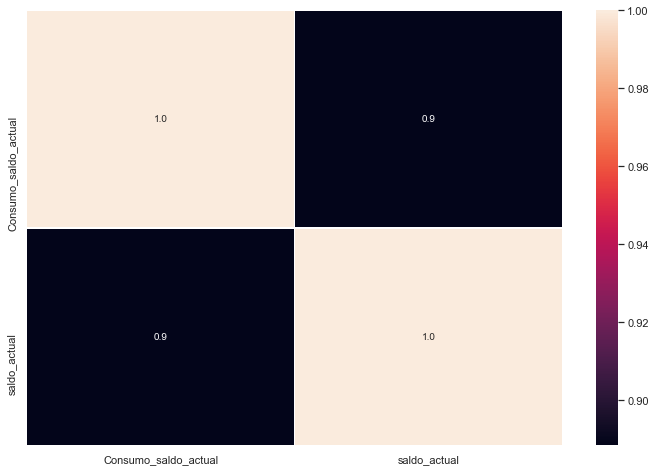

In [101]:
if len(numerical_corr_columns) > 0:
    f, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(select_df[numerical_corr_columns].corr(method='pearson'), fmt=".1f", linewidths=.5, ax=ax, annot=True)
else:
    print("¡No se evalúan correlaciones!")

Vamos a ignorar esta correlación y a permitir que la selección de características nos muestre que variables influyen más el proceso de modelado.

<!-- Dado el mapa de calor anterior, logramos identificar características que tienen correlaciones fuertes, es decir, sospechamos que tengan una relación pero no confirmada. En este punto, vamos a estudiar las distribuciones por grupos de variables y trataremos de comprender estadisticamente si realmente algunas de las variables las podemos descartar dado que tienen una relación significativa. -->

In [362]:
# numerical_corr_columns = []

# for i, r in select_df[numerical_columns].corr(method='pearson').reset_index().iterrows():
#     for c in numerical_columns:
#         if c != r['index'] and (r[c] < lower_threshold or r[c] > upper_threshold):
#             if c not in [k['column'] for k in numerical_corr_columns] \
#                 and (r['index'], c) not in [(k['index'], k['column']) for k in numerical_corr_columns] \
#                 and (r['index'], c) not in [(k['column'], k['index']) for k in numerical_corr_columns]:
#                 numerical_corr_columns.append({
#                     "index": r['index'], "column": c, "value": r[c]
#                 })
            
# corr2_df = pd.DataFrame(numerical_corr_columns)
# corr2_df

<!-- Como podemos notar en la tabla, existen variables que por su fuerte correlación amerita realizar un estudio más a fondo y verificar si existe o no una relación. Para lograr esto, buscamos que el **p-value** sea menor que **0.05**, en ese caso se concluye que la relación es estadísticamente significativa. -->

In [363]:
# def pearson_and_pvalue(list1, list2):
#     pearson, pvalue = pearsonr(list1, list2)
#     return round(pearson, 2), round(pvalue, 6)

# corr2_df['complete'] = corr2_df.apply(
#     lambda r: pearson_and_pvalue(select_df[r["index"]], select_df[r["column"]]), 
#     axis=1
# )
# corr2_df

<!-- Lo anterior indica que todas las relaciones estudiadas tienen un **p-value** por debajo del **0.05** y por tanto, todas son estadísticamente significativas. Vamos a seleccionar aquellas variables que por concepto de negocio realmente podrían ser descartadas del modelado, más por su significancia en negocio que de forma numérica. -->

In [364]:
# sns.pairplot(select_df[target_column + ['saldo_actual', 'Consumo_saldo_actual']])

<!-- **saldo_actual vs. Consumo_saldo_actual:** Vemos que la distribución marca una clara tendencia en ambas variables, pero se notan algunos factores de dispersión que hace sospechar que su relación no sea tan fuerte desde negocio y que algunos valores salgan de la tendencia lineal. Se conservarán ambas variables. -->

### Construcción de variables dummy (categóricas a matriz dispersa)

En este proceso vamos a convertir las variables categóricas en características dummy, es decir, las vamos a transformar en una matriz dispera de ceros y unos, donde cada valor se convierte en una columna con un indicador 0 o 1. Esto se realizará para poder ejecutar modelos, ya que estos algorítmos no comprender las variables de este tipo.

In [102]:
select2_df = select_df.copy()

In [103]:
select2_df = pd.get_dummies(select2_df, columns=categorical_columns)
select2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Creditos                           2896 non-null   int64  
 1   saldo_actual                       2896 non-null   float64
 2   saldo_vencido                      2896 non-null   float64
 3   Promedio de limite_credito         2896 non-null   float64
 4   Promedio de credito_maximo         2896 non-null   float64
 5   Promedio de cantidad_cuotas        2896 non-null   int64  
 6   Promedio de valor_cuota            2896 non-null   float64
 7   ahorro_impacto                     2896 non-null   int64  
 8   bienestar_financiero_impacto       2896 non-null   int64  
 9   coaching_impacto                   2896 non-null   int64  
 10  Tiene_ahorro                       2896 non-null   int64  
 11  monto_ahorro                       2896 non-null   float

In [104]:
print(target_column)

['Y']


In [105]:
features_columns = select2_df.columns.tolist()
print(features_columns)

['Creditos', 'saldo_actual', 'saldo_vencido', 'Promedio de limite_credito', 'Promedio de credito_maximo', 'Promedio de cantidad_cuotas', 'Promedio de valor_cuota', 'ahorro_impacto', 'bienestar_financiero_impacto', 'coaching_impacto', 'Tiene_ahorro', 'monto_ahorro', 'monto_total', 'Comunicaciones_saldo_actual', '%_comunicaciones', 'Comunicaciones_pagos_vencidos', 'Consumo_saldo_actual', '%_consumo', 'consumo_pagos_vencidos', 'genero_FEMENINO', 'genero_MASCULINO', 'genero_OTRO', 'Antiguedad_6 meses o mas', 'Antiguedad_Menos de 6 meses', 'mop_historico_Al día', 'mop_historico_Mora 30 a 120 días', 'mop_historico_Mora > 120 días', 'mop_historico_Sin registro', 'Garantia_Tipo garantia 1', 'Garantia_Tipo garantia 2', 'rango_edad_(16.999, 26.0]', 'rango_edad_(26.0, 32.0]', 'rango_edad_(32.0, 79.0]', 'perfil_usuario_Alto', 'perfil_usuario_Bajo', 'perfil_usuario_Joven', 'perfil_usuario_Medio', 'perfil_usuario_Sin registro', 'perfil_usuario_Usuario en quiebra']


In [106]:
len(features_columns)

39

### Selección de características relevantes

A continuación realizaremos un par de procesos que nos permitirán intuir que variables son más relevantes para el modelado. Por un lado, vamos a ejecutar una **eliminación recursiva de características** con el fin de descartar aquellas variables que aportan poco al modelo. En segundo lugar, intentaremos con una **eliminación por importancia** usando un modelo de Árboles de decisión, clasificando las variables según su influencia en el modelado.

#### Eliminación recursiva de características

Utilizando un procedimiento de modelado inicial con **Logistic Regression**, vamos a seleccionar las variables más importantes del conjunto de datos realizando una **eliminación recursiva** hasta dejar una cantidad de variables que tengan un aporte realmente significativo. El modelo será usado con soporte para datos desbalanceados.

In [261]:
X, y = select2_df[features_columns], target
X_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)

# Hacemos un split datos de entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.6)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1737, 39), (1159, 39), (1737,), (1159,))

In [262]:
def get_rfe_analysis(X, y, X_test, y_test, feature_list, class_report=False):
    score_list, support_list = [], []
    for n_features in feature_list:
        model = LogisticRegression(random_state=0, class_weight="balanced")
        selector = RFE(estimator=model, n_features_to_select=n_features)
        selector.fit(X, y)
        score_list.append(selector.score(X_test, y_test))
        support_list.append(selector.support_)
        if class_report:
            y_pred = model.fit(X, y).predict(X_test)
            print(classification_report(y_test, y_pred))
    result_dict = {
        "label": feature_list,
        "score": score_list,
        "support": support_list,
    }
    return pd.DataFrame(result_dict)

<AxesSubplot:xlabel='label', ylabel='score'>

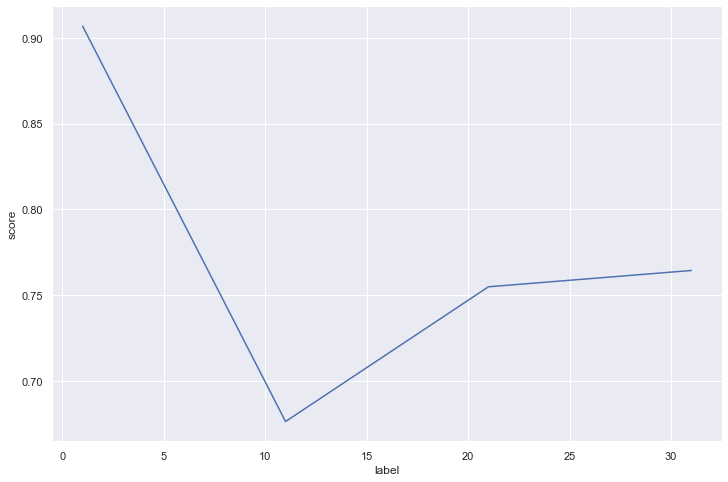

In [263]:
rfe_result = get_rfe_analysis(X_train, y_train, X_test, y_test, feature_list=list(range(1, len(features_columns)+1, 10)))

f, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=rfe_result, x='label', y='score', ax=ax)

Tal parece que de 21 variables en adelante el **score** de entrenamiento se estabiliza un poco en **78%** aproximadamente. Considerando esto, a seleccionar la mejor cantidad de variables en el rango 20 caracteristicas en adelante, dado que en este se presenta un pico.

<AxesSubplot:xlabel='label', ylabel='score'>

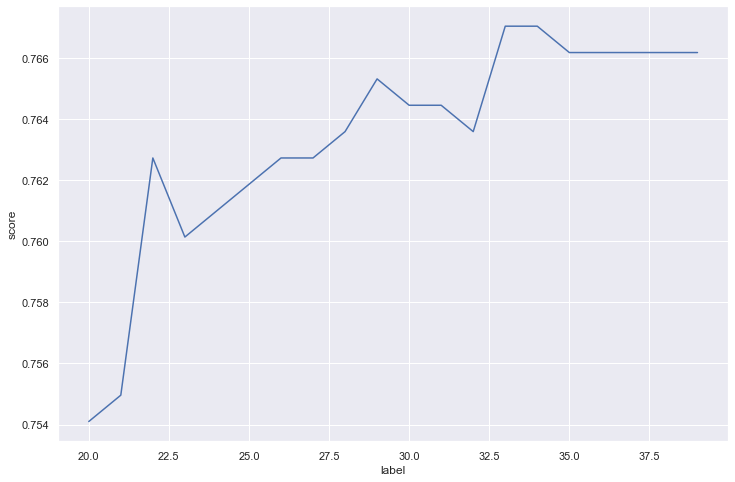

In [265]:
rfe_result_2 = get_rfe_analysis(X_train, y_train, X_test, y_test, feature_list=list(range(20, len(features_columns)+1, 1)))

f, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=rfe_result_2, x='label', y='score', ax=ax)

De lo anterior concluímos lo siguiente: Al realizar una **eliminación recursiva de características** encontramos que el **score** de entrenamiento más apropiado a partir de **21 características**, cantidad que usaremos para el modelado en caso de decidir esta técnica.

In [269]:
result_final = get_rfe_analysis(X_train, y_train, X_test, y_test, feature_list=[21], class_report=True)
support_list = result_final.support.tolist()[0]

rfe_columns = [column for i, column in enumerate(X.columns) if support_list[i]]
print(len(rfe_columns))
print(rfe_columns)

              precision    recall  f1-score   support

           0       0.98      0.78      0.87      1124
           1       0.06      0.46      0.11        35

    accuracy                           0.77      1159
   macro avg       0.52      0.62      0.49      1159
weighted avg       0.95      0.77      0.84      1159

21
['Creditos', 'saldo_actual', 'saldo_vencido', 'Promedio de limite_credito', 'Promedio de credito_maximo', 'Promedio de cantidad_cuotas', 'Promedio de valor_cuota', 'ahorro_impacto', 'coaching_impacto', 'Comunicaciones_saldo_actual', '%_comunicaciones', 'Comunicaciones_pagos_vencidos', 'Consumo_saldo_actual', '%_consumo', 'genero_FEMENINO', 'Antiguedad_6 meses o mas', 'Antiguedad_Menos de 6 meses', 'mop_historico_Mora 30 a 120 días', 'perfil_usuario_Alto', 'perfil_usuario_Joven', 'perfil_usuario_Sin registro']


### Eliminación de características por importancia (random forest)

Realizaremos un proceso de **eliminación de variables usando un modelo Ensemble**, en este caso **Random Forest**, para encontrar características que sean mucho más significativas para el modelado.

Dado que la variable objetivo esta desbalanceada, vamos a ejecutar el modelado usando ajuste del parámetro **pesos de las clases**, con el fin de evitar problemas de ajuste en la clase minoritaria.

In [304]:
feature_percentiles = np.arange(0, 1, 0.05)

X, y = select2_df[features_columns], target
X_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)

# Hacemos un split datos de entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.6)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1737, 39), (1159, 39), (1737,), (1159,))

              precision    recall  f1-score   support

           0       0.99      0.72      0.83      1124
           1       0.08      0.80      0.15        35

    accuracy                           0.72      1159
   macro avg       0.54      0.76      0.49      1159
weighted avg       0.96      0.72      0.81      1159



<AxesSubplot:xlabel='metric', ylabel='value'>

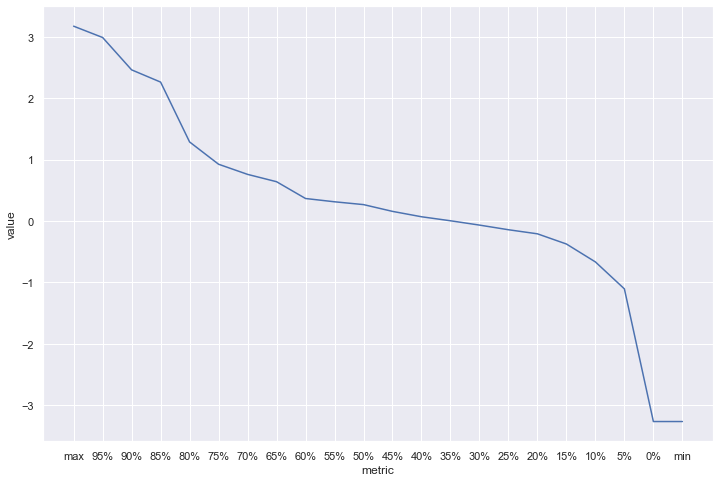

In [305]:
model_rf = LogisticRegression(random_state=0, class_weight='balanced')
model_rf.fit(X_train, y_train)
print(classification_report(y_test, model_rf.predict(X_test)))

feature_names = np.array(X_train.columns)
feature_importances = pd.Series(model_rf.coef_[0])

# Calculamos más percentiles para apreciar mejor los cambios entre ellos
feature_imp_report = pd.DataFrame(feature_importances.describe(percentiles=feature_percentiles)).reset_index()[3:]
feature_imp_report.columns = ['metric', 'value']
feature_imp_report = feature_imp_report.sort_values('value', ascending=False)

f, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=feature_imp_report, x='metric', y='value', ax=ax)

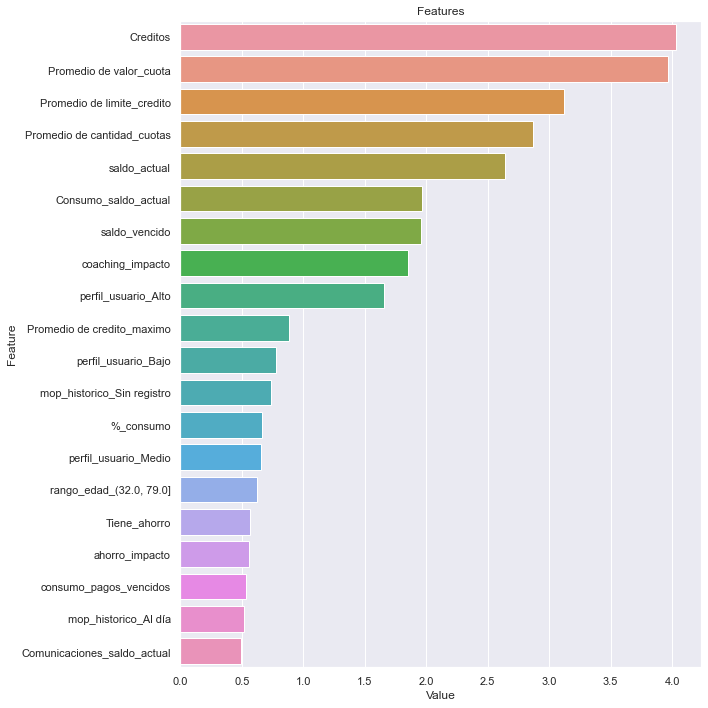

['Creditos', 'Promedio de valor_cuota', 'Promedio de limite_credito', 'Promedio de cantidad_cuotas', 'saldo_actual', 'Consumo_saldo_actual', 'saldo_vencido', 'coaching_impacto', 'perfil_usuario_Alto', 'Promedio de credito_maximo', 'perfil_usuario_Bajo', 'mop_historico_Sin registro', '%_consumo', 'perfil_usuario_Medio', 'rango_edad_(32.0, 79.0]', 'Tiene_ahorro', 'ahorro_impacto', 'consumo_pagos_vencidos', 'mop_historico_Al día', 'Comunicaciones_saldo_actual']


In [301]:
def plot_importance(features, feature_importances, limit):
    feature_imp = pd.DataFrame({'Value': feature_importances, 'Feature': features})
    feature_imp_order = feature_imp.sort_values(by="Value", ascending=False)
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp_order[0:limit])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    
    return feature_imp_order[:limit].Feature.tolist()

most_important = plot_importance(X_train.columns, feature_importances, 20)

print(most_important)

A partir del percentil **75%** se nota estabilidad en los valores de importancia de las características, esto quiere decir que esa cantidad de variables explican de forma suficiente los datos y nos permitiran un buen modelamiento. Usaremos esta última métrica para configurar el algoritmo de **selección de características**.

In [306]:
selector = SelectFromModel(model_rf, threshold=feature_imp_report[feature_imp_report.metric == '75%'].iloc[0].value)
selector.fit(X_scaled, y)

len(feature_names[selector.get_support()])

14

In [307]:
ife_columns = feature_names[selector.get_support()]
print(ife_columns)

['Creditos' 'saldo_actual' 'saldo_vencido' 'Promedio de limite_credito'
 'Promedio de credito_maximo' 'Promedio de cantidad_cuotas'
 'Promedio de valor_cuota' 'coaching_impacto'
 'Comunicaciones_saldo_actual' 'Comunicaciones_pagos_vencidos'
 'Consumo_saldo_actual' 'perfil_usuario_Alto' 'perfil_usuario_Joven'
 'perfil_usuario_Sin registro']


<!-- En conclusión, luego de todo el proceso de **selección de características**, se decide utilizar el método de **eliminación recursiva** realizado con el modelo *LogisticRegression* y *RFE (Recursive Feature Elimination)*. -->

En conclusión, luego de todo el proceso de **selección de características**, se decide utilizar el método de **eliminación por importancia** realizado con el modelo *Logistic Regression* y *SelectFromModel*.

<!-- **NOTA IMPORTANTE:** Vamos a ignorar la eliminación de características y trabajaremos con todas para ir ajustando el modelo. -->

In [308]:
if len(rfe_columns) < len(ife_columns):
    print(sum([True if i in ife_columns else False for i in rfe_columns]))
else:
    print(sum([True if i in rfe_columns else False for i in ife_columns]))

14


In [309]:
# X = X.copy()
# X = X.copy()[rfe_columns]
X = X.copy()[ife_columns]

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Creditos                       2896 non-null   int64  
 1   saldo_actual                   2896 non-null   float64
 2   saldo_vencido                  2896 non-null   float64
 3   Promedio de limite_credito     2896 non-null   float64
 4   Promedio de credito_maximo     2896 non-null   float64
 5   Promedio de cantidad_cuotas    2896 non-null   int64  
 6   Promedio de valor_cuota        2896 non-null   float64
 7   coaching_impacto               2896 non-null   int64  
 8   Comunicaciones_saldo_actual    2896 non-null   float64
 9   Comunicaciones_pagos_vencidos  2896 non-null   int64  
 10  Consumo_saldo_actual           2896 non-null   float64
 11  perfil_usuario_Alto            2896 non-null   uint8  
 12  perfil_usuario_Joven           2896 non-null   u

In [310]:
feature_names = np.array(X.columns)

X.shape, feature_names.shape

((2896, 14), (14,))

In [311]:
with open('output/columns.pkl', 'wb') as f:
    pickle.dump(feature_names, f)

### Balanceo datos en variable objetivo

In [312]:
y.value_counts() / y.shape[0]

0   0.97
1   0.03
Name: Y, dtype: float64

<AxesSubplot:xlabel='Y', ylabel='count'>

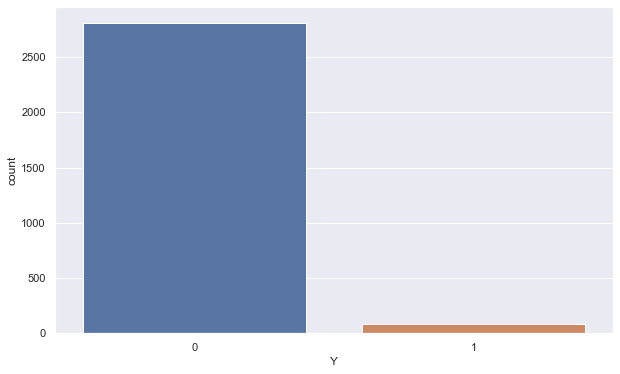

In [313]:
f, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x=y, ax=ax)

Como se puede apreciar, hay un desbalance notable entre las personas que fueron **Aceptadas** y **Rechazadas**. Los aceptados apenas suman el 3% de la población. Dado lo anterior, vamos a buscar una forma de adecuada de balancear los datos para el proceso de entrenamiento sin desmejorar las condiciones del mismo, dado que un estimador para la clase **Aceptadas** es probable que no funcione bien o no prediga bien una observación nueva.

Iniciaremos entonces a estudiar algunas **estrategías de balanceo** de nuestra variable objetivo hasta determinar la mejor opción de modelado, es decir, los mejores parámetros para un modelado confiable y con alta precisión en nuestra muestra desbalanceada. Propongo las siguientes dos técnicas:

* **Ajustando parámetros de pesos de los modelos de clasificación**, por ejemplo, la regresión logística cumple este propósito. Tiene un parámetro para balanceo de las clases y abstrae esta implementación. Random Forest tiene la misma característica.

* **Ensamble de métodos balanceados** que utiliza las ventajas de los modelos tipo Ensemble para entrenar y luego decide por "votación" el resultado final, usando al mismo tiempo estrategías de balanceo de clases.

* **Combinación de Resampling con Smote-Tomek** que nos permite en simultáneo realizar un subsampling en la clase mayoritaría **Rechazado** y un oversampling en la minoritaría **Aceptado** (usando vecinos más cercanos agrega puntos en línea recta). El algoritmo de **Tomek** lo usaremos para undersampling que quita los bordes y deja ver mejor la frontera entre las clases.

**NOTA:** Otra alternativa es **modificar el conjunto de datos y equilibrar las clases**, pero esto es peligroso dado que los datos de la clase minoritaria son muy pocos y estaremos eliminando muestras importantes para el entrenamiento. Por otro lado, podemos aplicar **generación de muestras artificiales o sintéticas**, pero en este caso, y dado que la clase minoritaria es tan insuficiente, podemos alterar demasiado la distribución de los datos al tratar de aumentar tanto una de las clases, considerando que no queremos sacrificar datos de la clase mayoritaría.

### Preparación datos de entrenamiento y prueba

Se realizará un particionamiento de los datos, 60% para entrenar y el resto para validar los modelos (por el hecho de estar sumamente desbalanceados). Por otro lado, se elaborarán unas funciones para ejecutar los estimadores requeridos, ejecutando un Pipeline con un escalador (estandarizador de las unidades en las variables) de datos llamado **Min-Max**.

In [314]:
# Nombres de las clases
LABELS = ["rejected", "accepted"]

# Escalamos los datos
X_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)

# Hacemos un split datos de entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.6)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1737, 14), (1159, 14), (1737,), (1159,))

In [315]:
def run_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    return model, model.predict(X_test)

def show_results(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print(classification_report(y_test, pred_y))

## 4. Modelamiento con Regresión Logística

En primera instancia, vamos a utilizar el modelo **Logistic Regression** "a secas", es decir, lo ejecutamos sin parámetros de balanceo para poder apreciar las métricas de calidad y tomar decisiones con respecto a los parámetros que vamos a ajustar de ahí en adelante.

#### Modelado inicial sin balanceo de datos

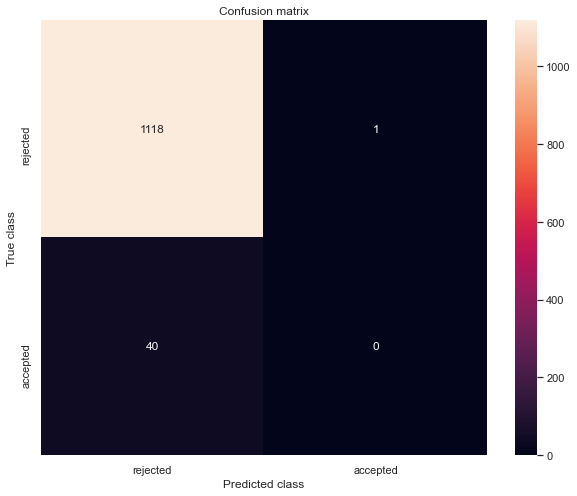

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1119
           1       0.00      0.00      0.00        40

    accuracy                           0.96      1159
   macro avg       0.48      0.50      0.49      1159
weighted avg       0.93      0.96      0.95      1159



In [316]:
model, pred_y = run_model(
    X_train, X_test, y_train, y_test, 
    LogisticRegression(random_state=0))

show_results(y_test, pred_y)

#### Ajustando parámetros "peso de clase" en los modelos

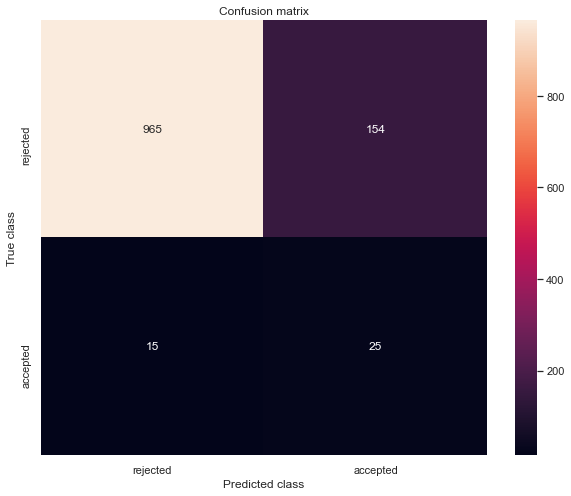

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      1119
           1       0.14      0.62      0.23        40

    accuracy                           0.85      1159
   macro avg       0.56      0.74      0.57      1159
weighted avg       0.96      0.85      0.90      1159



In [317]:
model, pred_y = run_model(
    X_train, X_test, y_train, y_test, 
    LogisticRegression(random_state=0, class_weight="balanced"))

show_results(y_test, pred_y)

#### Ensamble de métodos balanceados

En este caso vamos a utilizar el modelo **Balanced Bagging** de la librería **imbalanced learn** el cual nos ofrece una abstracción bastante profunda de un modelo basado en "votación" en conjunto con una balanceo de las clases.

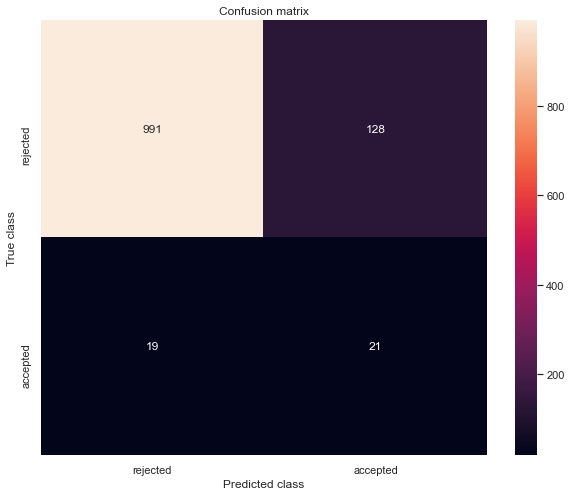

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      1119
           1       0.14      0.53      0.22        40

    accuracy                           0.87      1159
   macro avg       0.56      0.71      0.58      1159
weighted avg       0.95      0.87      0.91      1159



In [318]:
model, pred_y = run_model(
    X_train, X_test, y_train, y_test, 
    BalancedBaggingClassifier(
        base_estimator=LogisticRegression(random_state=0), 
        sampling_strategy='auto', replacement=False, random_state=0))

show_results(y_test, pred_y)

#### Combinación Resampling con Smote-Tomek

Before resampling Counter({0: 1692, 1: 45})
After resampling Counter({0: 1685, 1: 1685})


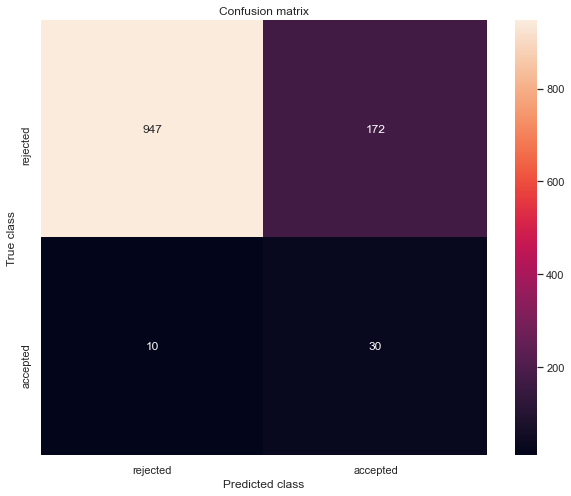

              precision    recall  f1-score   support

           0       0.99      0.85      0.91      1119
           1       0.15      0.75      0.25        40

    accuracy                           0.84      1159
   macro avg       0.57      0.80      0.58      1159
weighted avg       0.96      0.84      0.89      1159



In [319]:
os_us = SMOTETomek(random_state=1)
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("Before resampling {}".format(Counter(y_train)))
print ("After resampling {}".format(Counter(y_train_res)))

model, pred_y = run_model(
    X_train_res, X_test, y_train_res, y_test, 
    LogisticRegression(random_state=0))

show_results(y_test, pred_y)

## 5. Modelamiento con Árboles Aleatoreos

Vamos a utilizar el modelo **Random Forest** "a secas". Aplicaremos cada **estrategia de balanceo** con este modelo.

#### Modelado inicial sin balanceo de datos

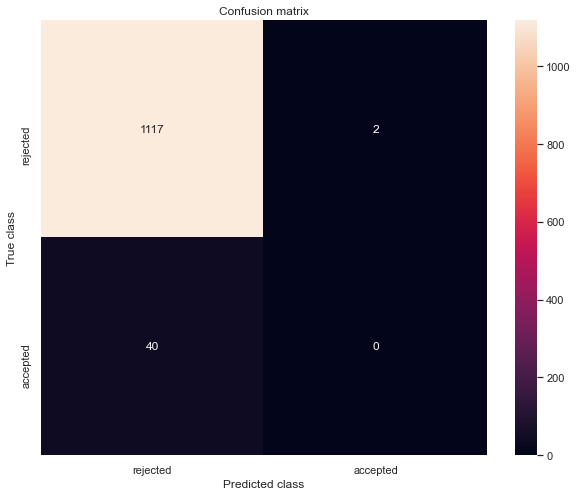

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1119
           1       0.00      0.00      0.00        40

    accuracy                           0.96      1159
   macro avg       0.48      0.50      0.49      1159
weighted avg       0.93      0.96      0.95      1159



In [320]:
model, pred_y = run_model(
    X_train, X_test, y_train, y_test, 
    RandomForestClassifier(random_state=0))

show_results(y_test, pred_y)

#### Ajustando parámetros "peso de clase" en los modelos

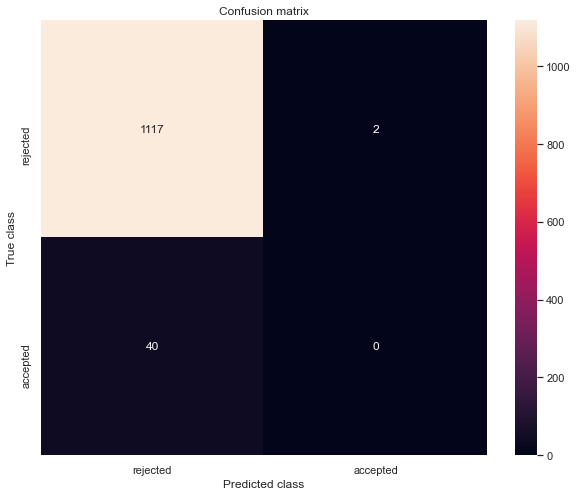

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1119
           1       0.00      0.00      0.00        40

    accuracy                           0.96      1159
   macro avg       0.48      0.50      0.49      1159
weighted avg       0.93      0.96      0.95      1159



In [321]:
model, pred_y = run_model(
    X_train, X_test, y_train, y_test, 
    RandomForestClassifier(random_state=0, class_weight="balanced"))

show_results(y_test, pred_y)

#### Ensamble de métodos balanceados

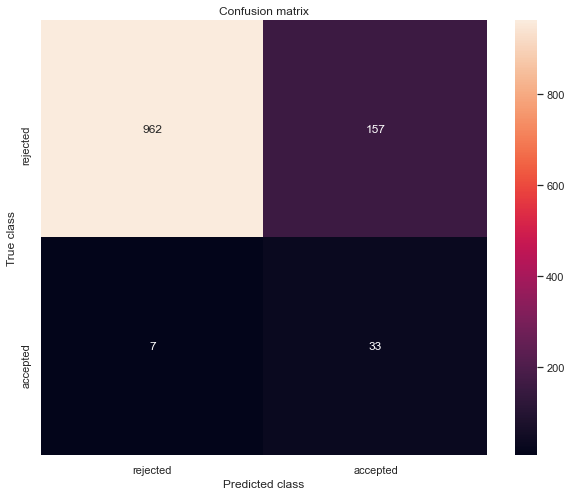

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1119
           1       0.17      0.82      0.29        40

    accuracy                           0.86      1159
   macro avg       0.58      0.84      0.60      1159
weighted avg       0.96      0.86      0.90      1159



In [322]:
model, pred_y = run_model(
    X_train, X_test, y_train, y_test, 
    BalancedBaggingClassifier(
        base_estimator=RandomForestClassifier(random_state=0), 
        sampling_strategy='auto', replacement=False, random_state=0))

show_results(y_test, pred_y)

#### Combinación Resampling con Smote-Tomek

Before resampling Counter({0: 1692, 1: 45})
After resampling Counter({0: 1685, 1: 1685})


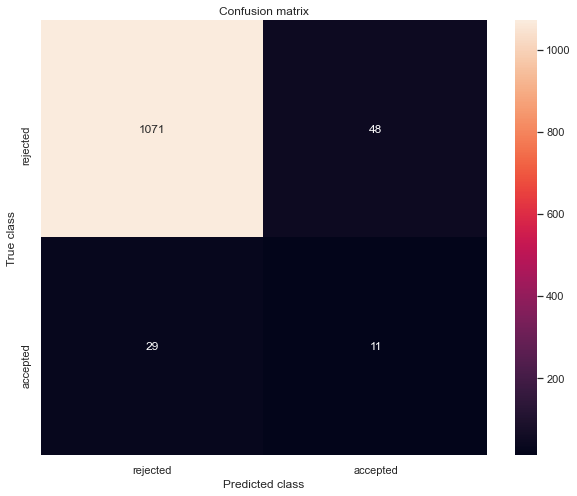

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1119
           1       0.19      0.28      0.22        40

    accuracy                           0.93      1159
   macro avg       0.58      0.62      0.59      1159
weighted avg       0.95      0.93      0.94      1159



In [324]:
os_us = SMOTETomek(random_state=1)
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)
 
print ("Before resampling {}".format(Counter(y_train)))
print ("After resampling {}".format(Counter(y_train_res)))

model, pred_y = run_model(
    X_train_res, X_test, y_train_res, y_test, 
    RandomForestClassifier(random_state=0))

show_results(y_test, pred_y)

## 6. Definición y justificación de la mejor métrica

En conclusión el modelo de **Random Forest** usando **Bagging Classifier** como método de Ensamble por "votación", entrega el mejor balance en la calidad predictiva, tanto para la clase **Rechazado** como para la clase minoritaría **Aceptado**.

A partir del reporte de clasificación podemos notar que el **Recall** para **Rechazado** es de **86%** y para **Aceptado** es de **82%**, que son métricas bastante ajustadas dado el alto desbalance en los datos. Vemos que los **F1-score** son de **92%** y **29%**, respectivamente; que en comparación con los otros métodos aplicados, genera el mejor balance en términos de las métricas. En este caso el valor de **Accuracy** es de **86%** que es en esencia una métrica aceptable para las condiciones del modelado. Se intuye por tanto, que tenemos una **calidad bastante aceptable** a la hora de predecir la clase que permite clasificar los **usuarios que ingresan al programa de reparación de deudas**.

Es importante resaltar que los 40 usuarios correspondientes a la clase **Aceptado**, 7 son fallos y 33 aciertos en la predicción, generando un buen balance predictivo en términos de la clase positiva. Además, notamos que con este método se presentó la menor cantidad de **Falsos Positivos** con un valor de **157 usuarios**. En conclusión, se pueden aceptar los fallos en la predicción de **rechazados que ingresan al programa** en comparativa con una mejor calidad para predecir los **verdaderamente aceptados**.

#### Preparación y almacenamiento de modelo final

In [327]:
model_final, pred_y_final = run_model(
    X_train, X_test, y_train, y_test, 
    BalancedBaggingClassifier(
        base_estimator=RandomForestClassifier(random_state=0), 
        sampling_strategy='auto', replacement=False, random_state=0))

# Almacenamos el modelo en un archivo pickle
with open('output/model.pkl', 'wb') as f:
    pickle.dump(model_final, f)

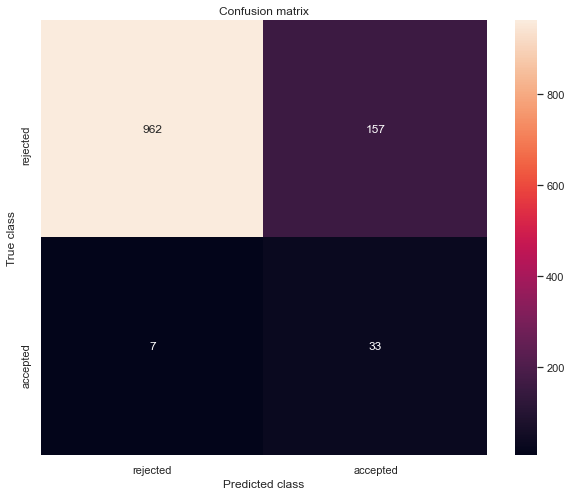

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1119
           1       0.17      0.82      0.29        40

    accuracy                           0.86      1159
   macro avg       0.58      0.84      0.60      1159
weighted avg       0.96      0.86      0.90      1159



In [326]:
show_results(y_test, pred_y_final)